#Random Forest To Predict the Winner Part 1

Given the data that we gathered from Riot's database, we wanted to figure out which features would be important to look at to predict the winning team. **Random Forest** is a useful tool to figure out how important each features were, based on how many decision trees they are found in. 

Random Forests is powerful because it is unexcelled in accuracy among current algorithms, runs efficiently on large data bases, and is able to give the relative importance of each variable that we are testing. Also, it has the advantage of being less sensitive to collinearity problems.

We'll use Random Forest on two data sets
* A dataframe using cumulative statistics from the end of the game 
* A dataframe using statistics from specific timestamps within the game (10 min, 20 min, 30 min).


In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

We've created a csv file using a package called 'Cassiopeia', which is used to query and parse through data we've obtained from Riot's database. We'll read in this csv file and create a **panda dataframe**. We'll print the head of the dataframe to see what we're working with.


In [7]:
dftouse = pd.read_csv('newdf.csv')
dftouse.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win
0,1,819,155,17067,3,17703,18.144444,-1,5,0,True,False,True,True,False,True
1,1,-685,24,-23447,0,-11396,-20.117208,1,-7,1,True,False,True,False,False,False
2,-1,658,16,-5988,0,-11734,-21.416667,1,-3,1,False,True,True,False,True,False
3,-1,-339,-127,-9102,-2,-17661,-17.531349,1,-6,0,False,False,False,False,False,False
4,0,756,162,12505,0,11899,26.059524,0,3,3,False,False,False,True,True,True


In [8]:
cols = list(dftouse.columns)

In [9]:
print cols

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret', 'win']


<span style = "font-size: 1.5em;">Getting on with the classifier</span>

Now, let's get on with our random forest classifier.

First we want to create mask values so we can split the dataframe into training and testing sets. To do that we import `train_test_split`, and create mask values.

In [10]:
###Random forest classifier
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.75)

In [11]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [12]:
#seeing if it worked out correctly
mask.shape, mask.sum()

((20223,), 15167)

We define lcols to be the columns of the variables that we want to know about. We do this by creating a list of the our column names and then removing 'win' as that is the response variable.

In [13]:
#Now we will be using a Random Forest classifier to figure out which features are more 
#important in determining the probability of a team winning. First, we split the data set.

#columns with values to fit as the X values
lcols = list(dftouse.columns.values)
#removing the win (y) response variables from the list
lcols.remove('win')
print(lcols)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret']


Don't forget to `import` the `RandomForestClassifier`!

In [14]:
from sklearn.ensemble import RandomForestClassifier

First, we'll create a `RandomForestClassifier` with the default parameters that we can use to optimize later.

In [15]:
clfForest = RandomForestClassifier()

We define two functions: `cv_optimize` and `do_classify`, derived from pset3.

`cv_optimize` takes in:
* clf as the original classifer (which in our case is clfForest) 
* the parameters to search over (we will be optimizing the n_estimator parameter)
* The X training matrix
* The y training vector

It returns the *best* parameter, according to the score.

`do_classify` uses `cv_optimize` and outputs the **X training matrix, y training vector, X test matrix, y test vector, the new optimized and fitted classifier, and the accuracy of the new model on the training and test sets**.

`do_classify` takes in:
* indf as the input dataframe (dftouse)
* featurenames as the variables we want to test (lcols)
* targetname as the variable we want predict (win)
* mask, the boolean vector indicator test set
* n_jobs, used for parallelization
* score_func, algorithm used to determine score

In [17]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split =None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

We want to optimize `n_estimators`, which is the number of trees in the forest. We wanted a large number of trees in the forest so we can better identify which features are more important; so we'll test to see up to 99 trees. Then, we'll run `do_classify`.

In [19]:
parameters = {"n_estimators": range(1, 100)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       dftouse, lcols, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 89} 0.978294941387 [mean: 0.96036, std: 0.00697, params: {'n_estimators': 1}, mean: 0.96372, std: 0.00277, params: {'n_estimators': 2}, mean: 0.97101, std: 0.00261, params: {'n_estimators': 3}, mean: 0.97229, std: 0.00386, params: {'n_estimators': 4}, mean: 0.97532, std: 0.00194, params: {'n_estimators': 5}, mean: 0.97492, std: 0.00343, params: {'n_estimators': 6}, mean: 0.97550, std: 0.00251, params: {'n_estimators': 7}, mean: 0.97629, std: 0.00211, params: {'n_estimators': 8}, mean: 0.97610, std: 0.00202, params: {'n_estimators': 9}, mean: 0.97526, std: 0.00286, params: {'n_estimators': 10}, mean: 0.97759, std: 0.00335, params: {'n_estimators': 11}, mean: 0.97630, std: 0.00209, params: {'n_estimators': 12}, mean: 0.97589, std: 0.00260, params: {'n_estimators': 13}, mean: 0.97705, std: 0.00337, params: {'n_estimators': 14}, mean: 0.97766, std: 0.00267, params: {'n_estimators': 15}, mean: 0.97701, std: 0.00186, params: {'n_estimators': 16}, mean: 0.97737, std: 0.0

The best parameter value is 89, with a score of 0.978. Let's print the clfForest to see its features.

In [20]:
clfForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's store the training and test sets in `reuse_split` so we can use them later with consistent sets.

In [21]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

<span style = "font-size: 1.34em"> Visualizing the results <span>

We'll first visualize the relative importance of each feature. The importances sum up to 1, which gives us an interesting insight into how important each feature was in predicting the winner. `feature_importances` returns the importances.

In [22]:
#We can plot the importances
importances = clfForest.feature_importances_

We'll sort the importances and column names so they match up.

In [23]:
imp_sort, lcols_sort = zip(*sorted(zip(importances, lcols)))

We'll use a horizontal bar chart to compare the importances. 

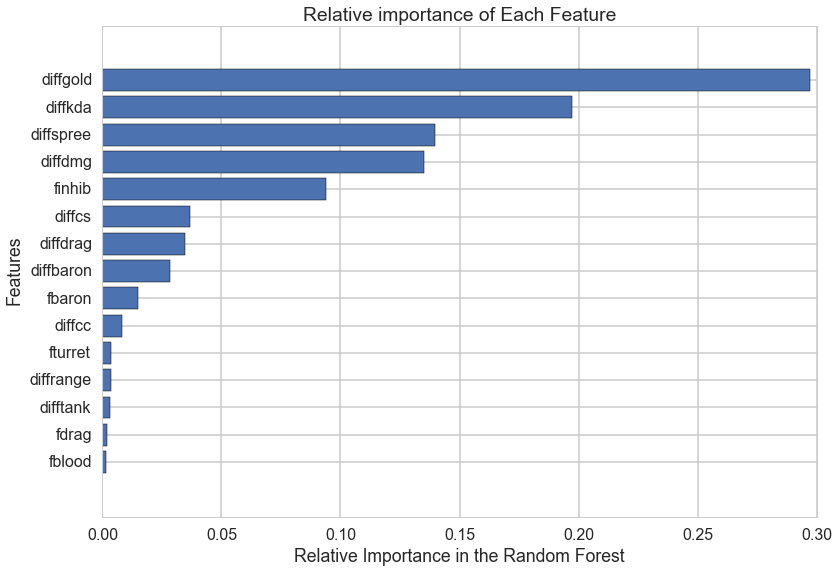

In [24]:
#plot importances
plt.barh(range(len(lcols_sort)),imp_sort,align='center')
plt.yticks(range(len(lcols_sort)),lcols_sort)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

We see that the results show us that the five most important variables in predicting the winner of the game are difference in gold earned, difference in kill-death-assist ratio, who got the first inhib, difference in damage dealt to champions, and difference in the number of killing sprees. Comparatively, we see that difference in the number of type of champions, such as "tank" and "ranged", were very weak variables, as well as who got first blood and who got first turret. 

Let's create some more visuals to see how these visuals interact with the wins. First, let's make a new dataframe with only the blue team wins, and a new dataframe with only red team wins.

In [25]:
bluewins = dftouse.query('win == True')
redwins = dftouse.query('win == False')

First, we plotted a histogram of the gold difference (in thousands) of all games. Positive values indicate that blue team had more gold amassed.

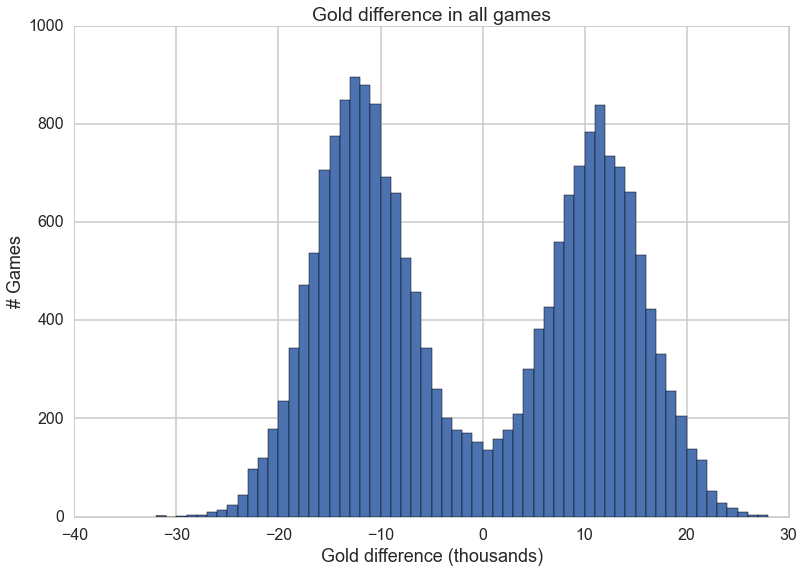

In [26]:
#all games
plt.hist(np.array(dftouse['diffgold'])/1000, bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('Gold difference (thousands)', fontsize = 18)
plt.title('Gold difference in all games')

We see that the resulting histogram shows 2 almost normally distributed curves, centered around about 12,000 and -12,000. This is probably because of how important gold difference is in predicting the winner of the game. We then plot the blue team wins and red team wins side by side to see if this is really the case. Once again, positive values indicate that the blue team had more gold.

/Users/leosjk/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


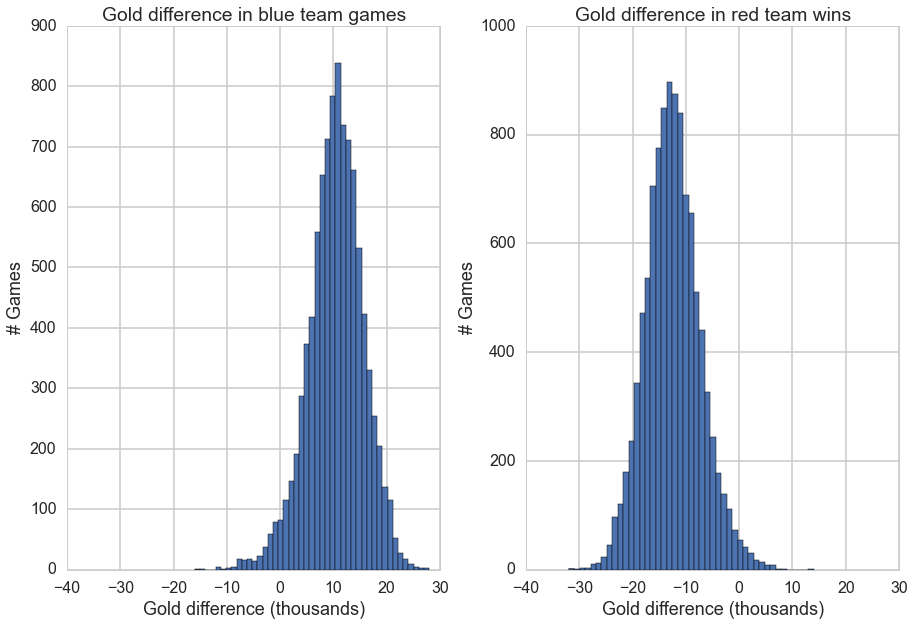

In [27]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins['diffgold'])/1000, bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax1.set_title('Gold difference in blue team games')
#red team wins
ax2.hist(np.array(redwins['diffgold'])/1000, bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax2.set_title('Gold difference in red team wins')

We see our prediction is correct - almost all the games that the blue team won, the gold difference is positive, while almost all the games that the red team won, the gold difference is negative (meaning red team had more gold). This provides us a visual into how gold difference is a good predictor to see who won the round at the end of the game. Let's do a kernel-density plot to see how they overlap.

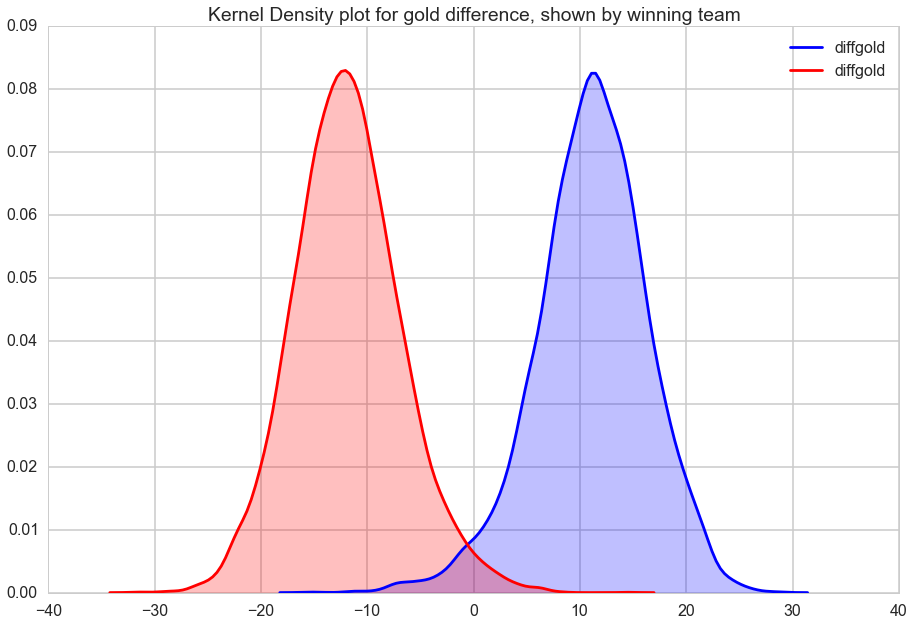

In [60]:
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for gold difference, shown by winning team")

We try this with the difference in kill-death-assist ratios as well. First, we graph all games.

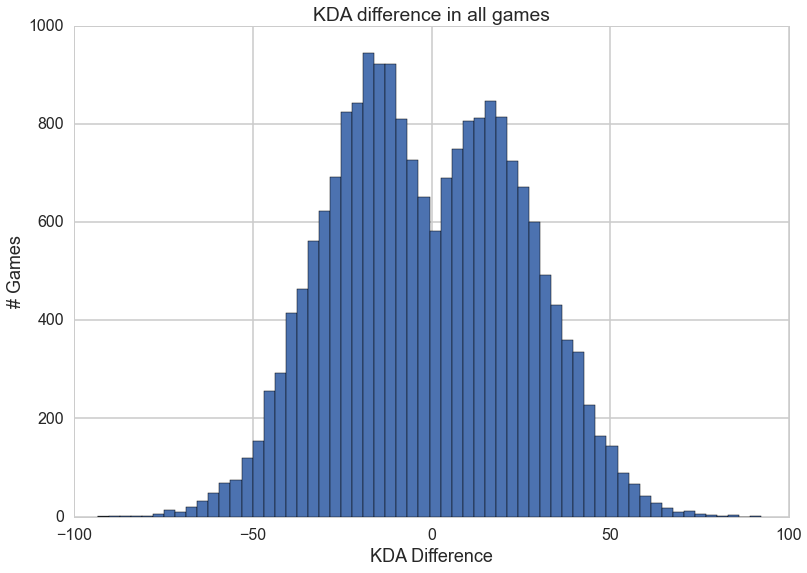

In [28]:
#all games
plt.hist(np.array(dftouse['diffkda']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('KDA Difference', fontsize = 18)
plt.title('KDA difference in all games')

The histogram above does not show the same amount of differentiation, per se, of the KDA differences between the blue and red teams. Nonetheless, the shape of the histogram, especially between -30 to 30, show that there might be some importance. Let's plot the blue team wins and red team wins side by side, using the KDA difference. Once again, positive values means the blue team has a higher KDA ratio.

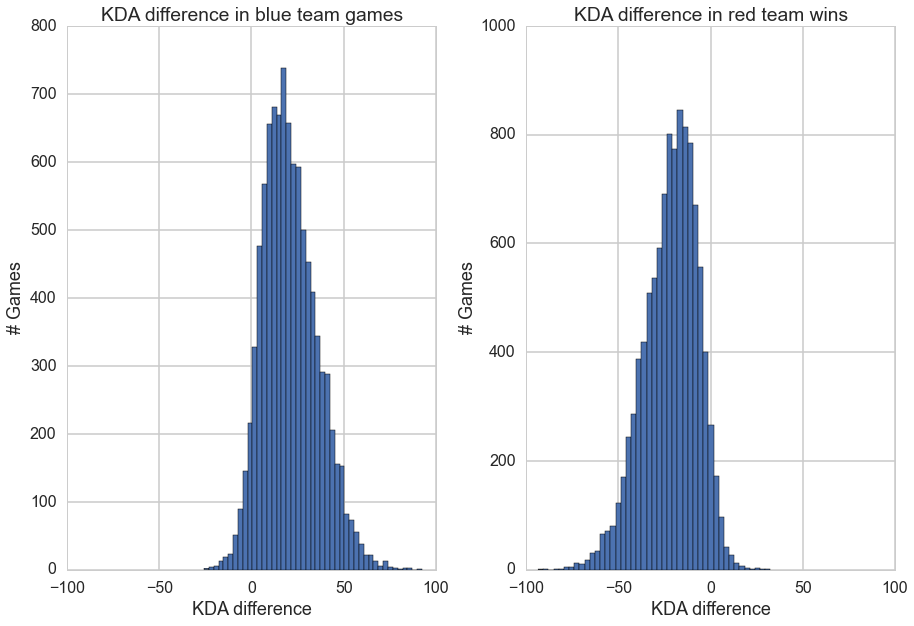

In [29]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins['diffkda']), bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('KDA difference', fontsize = 18)
ax1.set_title('KDA difference in blue team games')
#red team wins
ax2.hist(np.array(redwins['diffkda']), bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('KDA difference', fontsize = 18)
ax2.set_title('KDA difference in red team wins')

We see that the two histograms show that KDA difference is important, but not as important as gold difference, as there is a bit of a skew to the right on blue team wins and a bit of a skew to the left on red team wins. We see that the two histograms are not starkly separated like the gold difference histograms, with many matches more towards the middle of the joint histogram. Let's look at the KDE plot to compare the two.

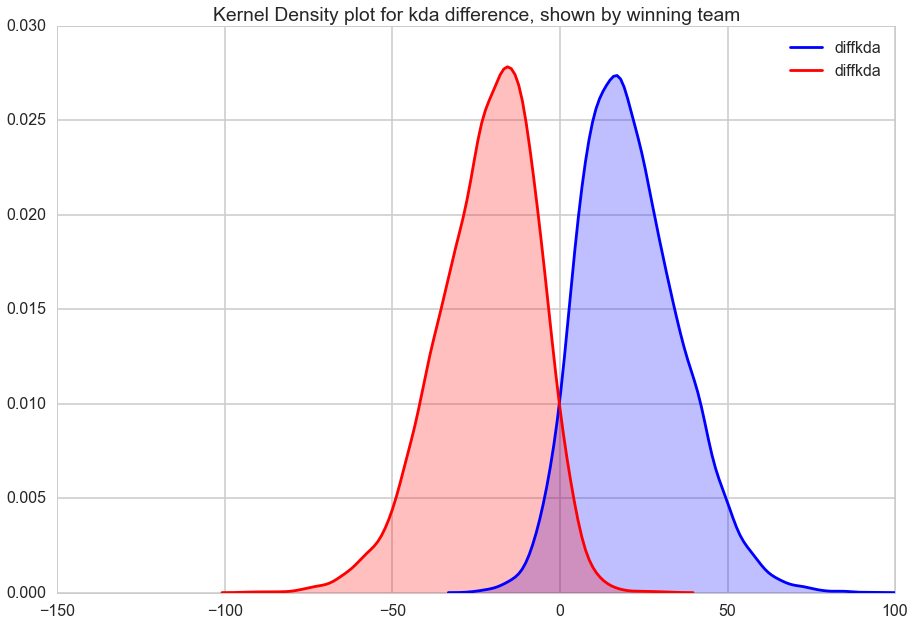

In [63]:
#KDE plot
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffkda'], ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffkda'], ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for kda difference, shown by winning team")

The KDE plot shows that there overlap, with the "peaks" of the curves much closer to each other than the gold difference.

Next, we plot the top indicator variable, `finhib`, which returns `True` if blue team destroyed an inhibitor first, and `False` if red team destroyed an inhibitor first. Let's do a histogram that compares blue team wins versus red team wins, marked by who got the first inhibitor.

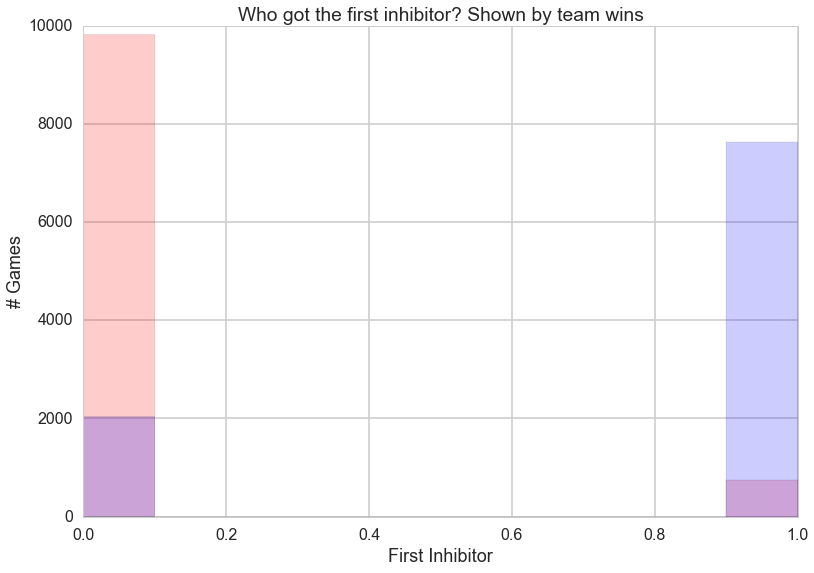

In [71]:
#all games, shown by team wins
plt.hist(np.array(redwins['finhib']), color = 'r', alpha = 0.2)
plt.hist(np.array(bluewins['finhib']), color = 'b', alpha = 0.2)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Inhibitor', fontsize = 18)
plt.title('Who got the first inhibitor? Shown by team wins')

We see that while there are quite a few games where the other team got the first inhibitor, our data shows that the majority of the wins are correlated with who got the first inhibitor.

Finally, let's look at two variables, "first blood" indicator and difference in duration of crowd control spells, that were shown to be "not important" by the random forest.

We'll use the kernel density plot for the `diffcc` variable:

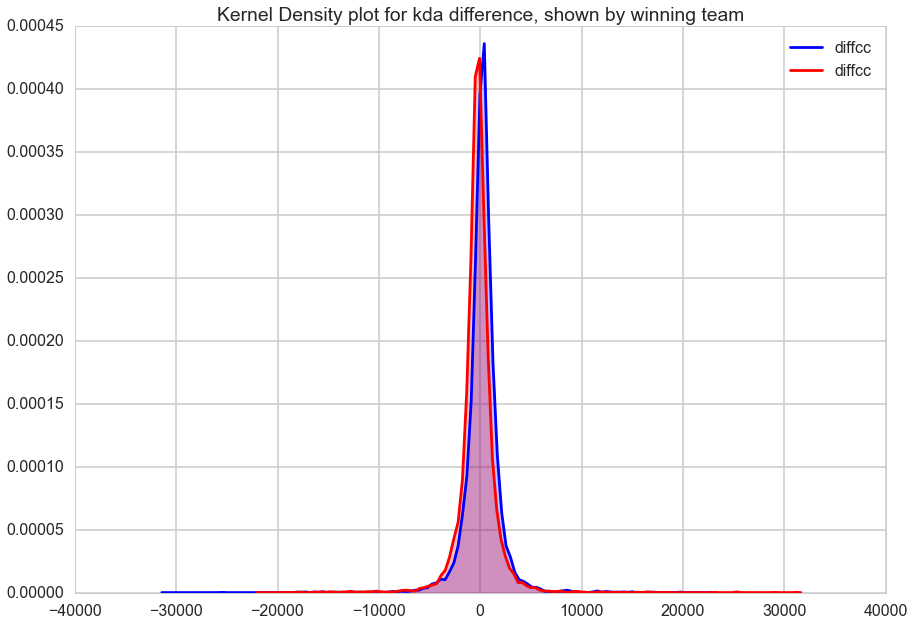

In [67]:
#KDE plot
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffcc'], ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffcc'], ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for kda difference, shown by winning team")

We see that there is much overlap, indicating that this variable would not be helpful in predicting the winner. Next, let's look at "first blood".

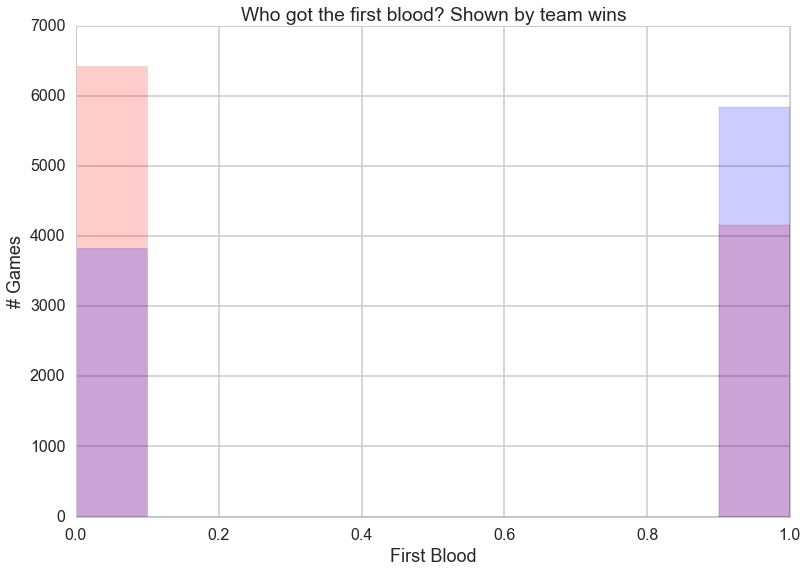

In [70]:
#all games, shown by team wins
plt.hist(np.array(redwins['fblood']), color = 'r', alpha = 0.2)
plt.hist(np.array(bluewins['fblood']), color = 'b', alpha = 0.2)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Blood', fontsize = 18)
plt.title('Who got the first blood? Shown by team wins')

We see that there are many games where the red team won without getting first blood, and there are many games where the blue team lost even after first blood. First blood isn't a good indicator.

<span style = "font-size: 1.2em"> Using a standardized data set </span>

We then standardized the dataset, to account for variability.

In [31]:
stddf = dftouse.copy()
stddf.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win
0,1,819,155,17067,3,17703,18.144444,-1,5,0,True,False,True,True,False,True
1,1,-685,24,-23447,0,-11396,-20.117208,1,-7,1,True,False,True,False,False,False
2,-1,658,16,-5988,0,-11734,-21.416667,1,-3,1,False,True,True,False,True,False
3,-1,-339,-127,-9102,-2,-17661,-17.531349,1,-6,0,False,False,False,False,False,False
4,0,756,162,12505,0,11899,26.059524,0,3,3,False,False,False,True,True,True


We'll create a list of variables to standardize.

In [32]:
#Standardizeable variables
stdz = list(dftouse.columns)
stdz.remove('win')
stdz.remove('fblood') 
stdz.remove('finhib')
stdz.remove('fdrag')
stdz.remove('fbaron')
stdz.remove('fturret')
print(stdz)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank']


We'll split the train and test set, using the same mask values we obtained earlier, giving us the same sets, just with standardized values.

In [34]:
#adding mask column
stddf['Mask'] = mask
#trainset to fit and standardize
trainset = stddf.query('Mask == True')
testset = stddf.query('Mask == False')
#test set train set
trainset = trainset[stdz]
testset = testset[stdz]

In [35]:
#standardizing our data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
preprocessing.StandardScaler().fit(trainset)
fitdf = preprocessing.StandardScaler().fit_transform(stddf[stdz])
newdf = pd.DataFrame(fitdf)
newdf.columns = trainset.columns

In [36]:
#replace values
stddf[stdz] = newdf
stddf.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win,Mask
0,1.012372,0.427762,1.615697,0.818152,1.487001,1.482770,0.744954,-0.848866,1.306314,-0.005191,True,False,True,True,False,True,False
1,1.012372,-0.346850,0.360326,-1.028140,0.112277,-0.836434,-0.728606,0.857049,-1.736486,0.957995,True,False,True,False,False,False,True
2,-0.875690,0.344841,0.283662,-0.232503,0.112277,-0.863373,-0.778652,0.857049,-0.722219,0.957995,False,True,True,False,True,False,True
3,-0.875690,-0.168648,-1.086705,-0.374414,-0.804205,-1.335757,-0.629018,0.857049,-1.482920,-0.005191,False,False,False,False,False,False,True
4,0.068341,0.395315,1.682778,0.610254,0.112277,1.020188,1.049785,0.004091,0.799181,2.884368,False,False,False,True,True,True,True


Let's split this new dataset.

In [37]:
Xmatrix = stddf[lcols].values
yvals = stddf['win'].values

In [38]:
##split to train and test
X_train = Xmatrix[mask]
X_test = Xmatrix[~mask]
y_train = yvals[mask]
y_test = yvals[~mask]

We'll fit the new set with the RandomForestClassifier from earlier.

In [40]:
#We can graph importances.
#First we fit
fitForest = clfForest.fit(X_train, y_train)

In [41]:
fitForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's plot the importances.

In [43]:
#We can plot the importances
importances2 = fitForest.feature_importances_

In [45]:
imp_sort2, lcols_sort2 = zip(*sorted(zip(importances2, lcols)))

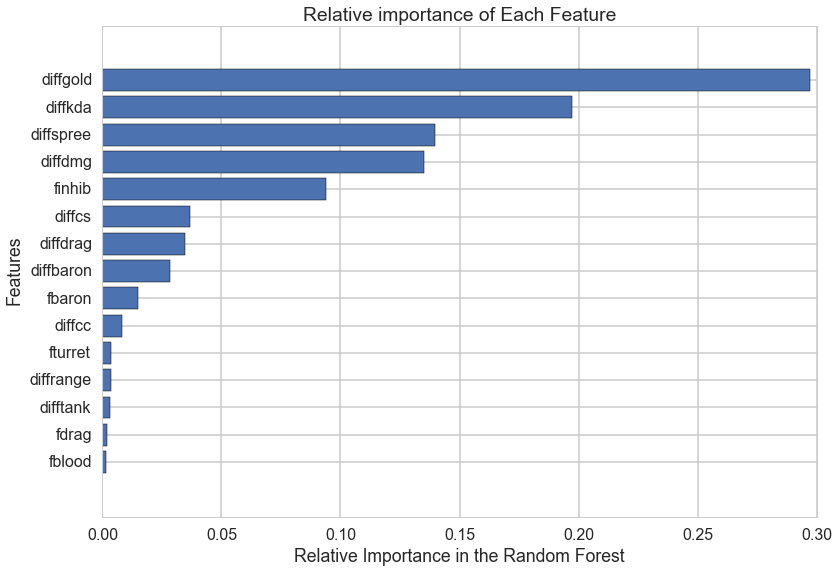

In [46]:
#plot importances
plt.barh(range(len(lcols_sort)),imp_sort,align='center')
plt.yticks(range(len(lcols_sort)),lcols_sort)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

As expected, we see that the variables that our earlier classifier found to be most important are still classified to be important. Let's graph the standardized gold difference values to visualize this quickly. First, histogram of all games:

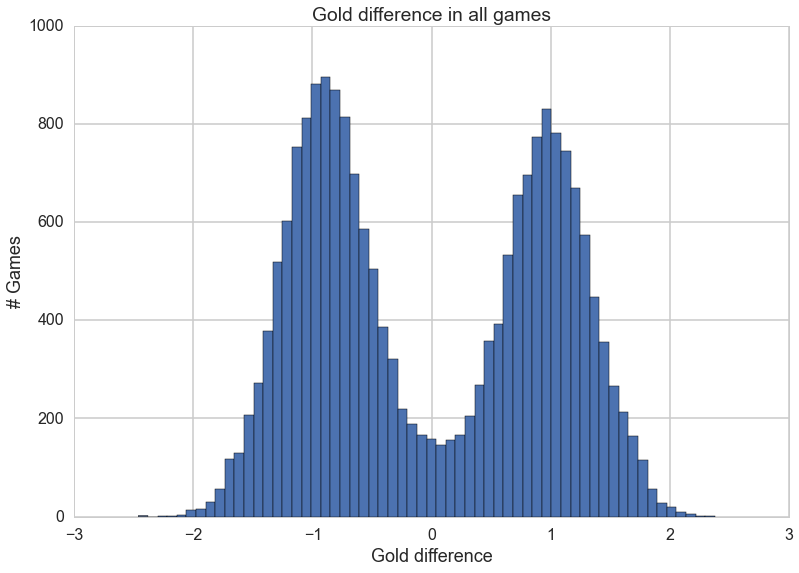

In [50]:
#all games
plt.hist(np.array(stddf['diffgold']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('Gold difference', fontsize = 18)
plt.title('Gold difference in all games')

Side-by-side histograms of gold differences by blue team wins and red team wins:

In [51]:
bluewins2 = stddf.query('win == True')
redwins2 = stddf.query('win == False')

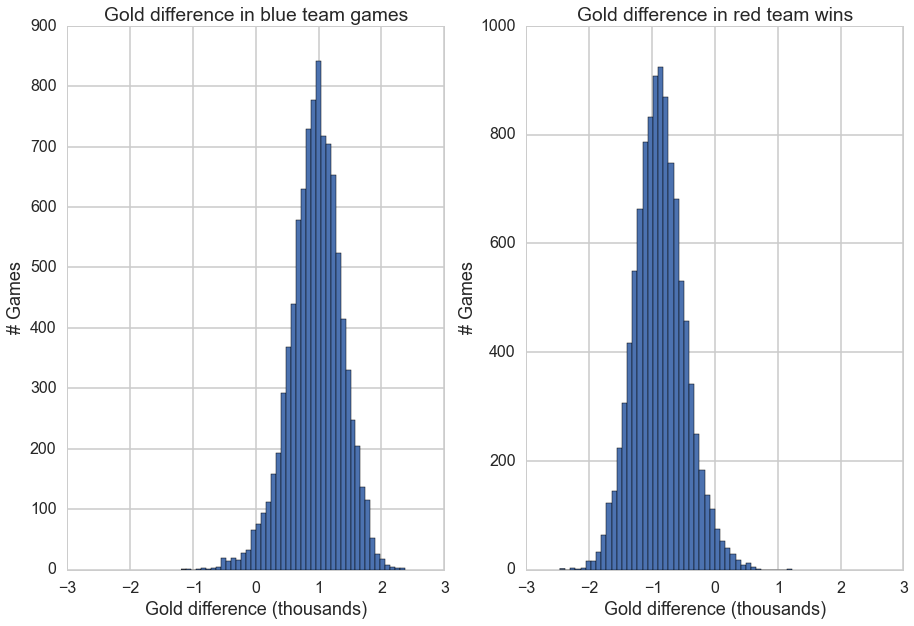

In [52]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins2['diffgold']), bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax1.set_title('Gold difference in blue team games')
#red team wins
ax2.hist(np.array(redwins2['diffgold']), bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax2.set_title('Gold difference in red team wins')

And finally, the KDE plot:

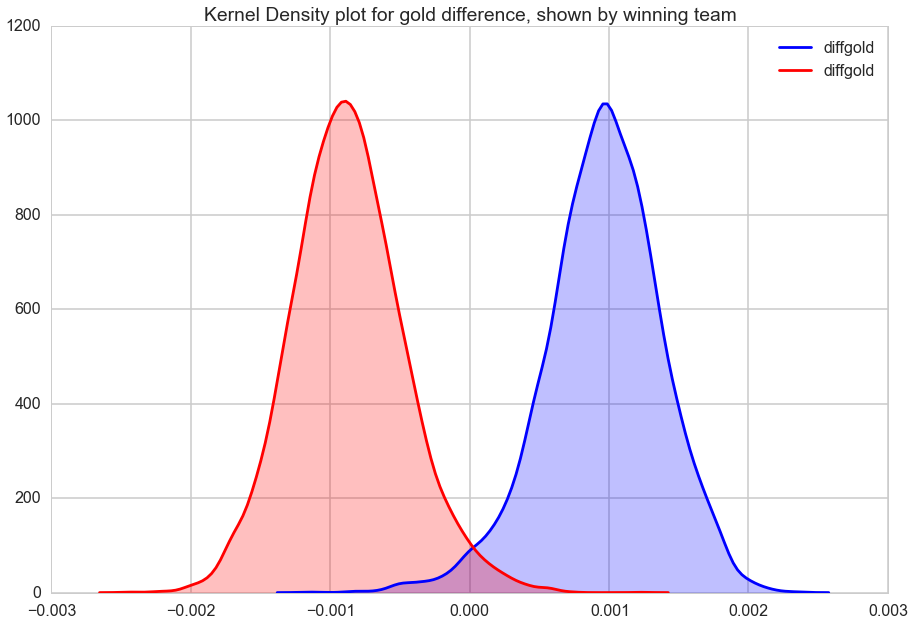

In [64]:
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins2['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins2['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for gold difference, shown by winning team")

Unsurprisingly, we see that the visuals return the same story with slightly different values (as we have standardized them).

<span style="font-size: 1.3em">Initial Conclusion, and Moving Forward to the Next Step</span>

The RandomForestClassifier gave us the relative importance of each feature we tested for, and we've identified variables that showed to be very important in predicting the winner. We see that the top five variables (difference in gold, difference in kill-death-assist ratio, difference in killing spree, difference in damage dealt to champions, and who got the first inhibitor) seem to be far more important than things like who got first blood or what the difference in creep score is. This makes sense. For example, the KDA ratio shows how many champion kills the teams obtained. Gold is correlated to win conditions (inhibitors and turrets), as well as champion kills and creep scores. More gold allows for more powerups, which makes the team with more gold more powerful, and more likely to win.

Next, we see that our model on the training set has an accuracy of 100%, while on the test test it shows an accuracy of 98%. However, this accuracy is *too high*. This is because the features we look at to be important (beyond the indicator variables of things like "first inhibitor") are values from the **end of the round**, which makes it almost a redundant prediction, as the team with *more kills and more gold* is almost certainly the team that will win.

In order to improve our model, we've decided to next look at important features, such as gold difference, at certain timestamps in the game to predict the end results. That is the next step we took.

#Random Forest To Predict the Winner Part 2 (markdowns needed here)
#haiiiiiiii

We now use a new dataframe, made from finaldf.csv, with new data from intervals of 10 mins of each game.

In [469]:
df = pd.read_csv('finaldf.csv')
df.astype(float)
df.head()

,diffbaron10,diffbaron20,diffbaron30,diffcs10,diffcs20,diffcs30,diffdrag10,diffdrag20,diffdrag30,diffgpm10,diffgpm20,diffgpm30,diffinhib10,diffinhib20,diffinhib30,diffkill10,diffkill20,diffkill30,diffturret10,diffturret20,diffturret30,diffwardk10,diffwardk20,diffwardk30,diffwardp10,diffwardp20,diffwardp30,fb10l,fb20l,fb30l,gametimes,matchid,win
0,0,0,1,4.3,5.700000,3.800000,0,2,1,199.6,336.900000,1127.800000,0,0,2,2,-1,9,0,1,5,0,1,2,-4,2,1,-1,-1,-1,1873,1364966345,True
1,0,0,1,2.3,1.200000,-0.200000,1,1,-2,-75.5,-279.100000,-157.700000,0,0,0,-3,-5,-5,-1,-3,2,2,-2,2,-4,-14,-27,-1,-1,-1,2062,1365000117,False
2,0,0,-1,4.5,-4.500000,4.109589,0,1,-1,223.6,-475.000000,-1263.013699,0,0,-2,3,-4,-6,1,-3,-4,0,2,1,3,-8,-1,1,1,1,1638,1365001477,False
3,0,0,-1,-2.9,-9.100000,-0.737705,0,-1,-1,-274.6,-765.800000,-892.254098,0,0,-2,-6,-10,-5,0,-3,-4,0,1,-1,0,-10,4,-1,-1,-1,1688,1365005581,False
4,0,0,0,2.4,11.838111,0.000000,0,0,0,126.0,1076.458685,0.000000,0,1,0,3,10,0,0,5,0,0,-1,0,-6,-11,0,-1,-1,-1,1193,1365190124,True


**Dividing the dataframes**
We are going to use 10 min marks to see the explanatory power at each.

In [470]:
#We want to divide the dataframe into 3 dataframes
#First we'll get a list of all the column names
allcols = list(df.columns.values)
#Then we split the columns into columns from 10,20,30 min
col1 = []
col2 = []
col3 = []
for col in allcols:
    if "10" in col:
        col1.append(col)
    if "20" in col:
        col2.append(col)
    if "30" in col:
        col3.append(col)
#We'll append the win column, since that's the end result we want to predict
col1.append('win')
col2.append('win')
col3.append('win')

In [471]:
print col1
print col2
print col3

['diffbaron10', 'diffcs10', 'diffdrag10', 'diffgpm10', 'diffinhib10', 'diffkill10', 'diffturret10', 'diffwardk10', 'diffwardp10', 'fb10l', 'win']
['diffbaron20', 'diffcs20', 'diffdrag20', 'diffgpm20', 'diffinhib20', 'diffkill20', 'diffturret20', 'diffwardk20', 'diffwardp20', 'fb20l', 'win']
['diffbaron30', 'diffcs30', 'diffdrag30', 'diffgpm30', 'diffinhib30', 'diffkill30', 'diffturret30', 'diffwardk30', 'diffwardp30', 'fb30l', 'win']


In [478]:
#gametimes @ 20 min, games that are longer >600
hidf = df.loc[df['gametimes']>600]
#gametimes @ 30 min, games that are longer >120
hidf2 = df.loc[df['gametimes']>1200]

In [482]:
#10 min values
df1 = df[col1]
#20 min values
df2 = hidf[col2]
#30 min values
df3 = hidf2[col3]

In [483]:
df1.head()

,diffbaron10,diffcs10,diffdrag10,diffgpm10,diffinhib10,diffkill10,diffturret10,diffwardk10,diffwardp10,fb10l,win
0,0,4.3,0,199.6,0,2,0,0,-4,-1,True
1,0,2.3,1,-75.5,0,-3,-1,2,-4,-1,False
2,0,4.5,0,223.6,0,3,1,0,3,1,False
3,0,-2.9,0,-274.6,0,-6,0,0,0,-1,False
4,0,2.4,0,126.0,0,3,0,0,-6,-1,True


In [484]:
df2.head()

,diffbaron20,diffcs20,diffdrag20,diffgpm20,diffinhib20,diffkill20,diffturret20,diffwardk20,diffwardp20,fb20l,win
0,0,5.700000,2,336.900000,0,-1,1,1,2,-1,True
1,0,1.200000,1,-279.100000,0,-5,-3,-2,-14,-1,False
2,0,-4.500000,1,-475.000000,0,-4,-3,2,-8,1,False
3,0,-9.100000,-1,-765.800000,0,-10,-3,1,-10,-1,False
4,0,11.838111,0,1076.458685,1,10,5,-1,-11,-1,True


In [486]:
df3.head()

,diffbaron30,diffcs30,diffdrag30,diffgpm30,diffinhib30,diffkill30,diffturret30,diffwardk30,diffwardp30,fb30l,win
0,1,3.800000,1,1127.800000,2,9,5,2,1,-1,True
1,1,-0.200000,-2,-157.700000,0,-5,2,2,-27,-1,False
2,-1,4.109589,-1,-1263.013699,-2,-6,-4,1,-1,1,False
3,-1,-0.737705,-1,-892.254098,-2,-5,-4,-1,4,-1,False
5,-1,-1.443299,0,-920.927835,-1,-8,-5,4,-17,-1,False


Creating new masks, because the size of the new dataframe is different from the first one? So gotta split it again

In [488]:
itrain2, itest2 = train_test_split(xrange(df.shape[0]), train_size=0.75)

In [489]:
mask=np.ones(df.shape[0], dtype='int')
mask[itrain2]=1
mask[itest2]=0
mask = (mask==1)

In [490]:
#seeing if it worked out correctly
mask.shape, mask.sum()

((20214,), 15160)

Now, we'll run `RandomForestClassifier()` on these three new dataframes to see what features are important at each 10-minute interval.

<span style = "font-size: 1.3em"> 10 min dataframe</span>

In [491]:
#new Random forest classifier for 10 min
newForest1 = RandomForestClassifier()

In [492]:
#10 min variables to test
lcols1 = list(df1.columns.values)
#win is the response we want to test for
lcols1.remove('win')
lcols1

['diffbaron10',
 'diffcs10',
 'diffdrag10',
 'diffgpm10',
 'diffinhib10',
 'diffkill10',
 'diffturret10',
 'diffwardk10',
 'diffwardp10',
 'fb10l']

In [493]:
#We want a lot of trees 
parameters = {"n_estimators": range(1, 100)}
##We use the same mask values from the previous part since 1) the matches are the same, just different data and
##2) we want the same training and test matchids when doing do_classify
newForest1, Xtrain1, ytrain1, Xtest1, ytest1 = do_classify(newForest1, parameters, 
                                                       df1, lcols1, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 99} 0.675805828077 [mean: 0.60358, std: 0.01115, params: {'n_estimators': 1}, mean: 0.51055, std: 0.00887, params: {'n_estimators': 2}, mean: 0.62983, std: 0.00556, params: {'n_estimators': 3}, mean: 0.58072, std: 0.00604, params: {'n_estimators': 4}, mean: 0.63658, std: 0.01079, params: {'n_estimators': 5}, mean: 0.60466, std: 0.00621, params: {'n_estimators': 6}, mean: 0.65311, std: 0.00339, params: {'n_estimators': 7}, mean: 0.62292, std: 0.00559, params: {'n_estimators': 8}, mean: 0.65242, std: 0.00540, params: {'n_estimators': 9}, mean: 0.62888, std: 0.00300, params: {'n_estimators': 10}, mean: 0.65622, std: 0.00876, params: {'n_estimators': 11}, mean: 0.63956, std: 0.00832, params: {'n_estimators': 12}, mean: 0.65848, std: 0.00409, params: {'n_estimators': 13}, mean: 0.63861, std: 0.00631, params: {'n_estimators': 14}, mean: 0.66242, std: 0.00913, params: {'n_estimators': 15}, mean: 0.64423, std: 0.00593, params: {'n_estimators': 16}, mean: 0.65960, std: 0.0

In [494]:
#Optimized is 99 trees
newForest1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=99, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [495]:
imp1 = newForest1.feature_importances_

In [496]:
imp1_sort, lcols1_sort = zip(*sorted(zip(imp1, lcols1)))

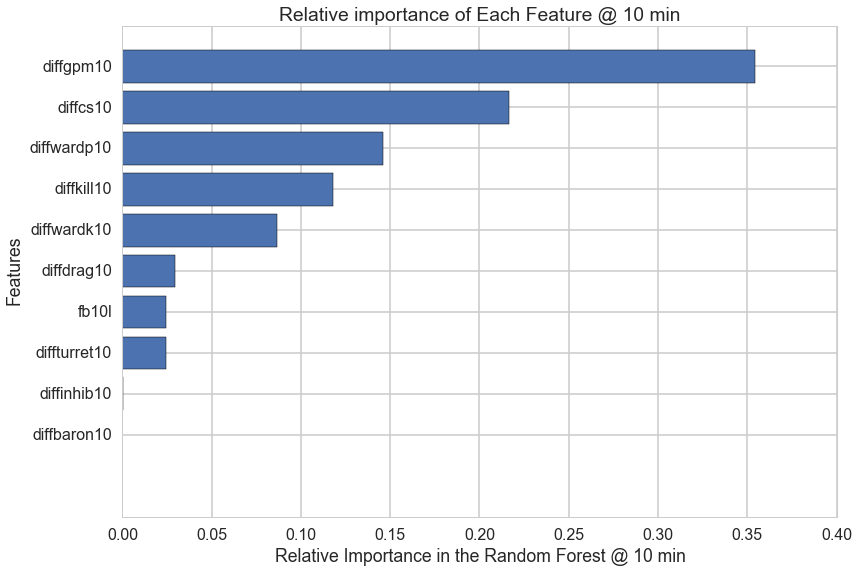

In [497]:
plt.barh(range(len(lcols1_sort)),imp1_sort,align='center')
plt.yticks(range(len(lcols1_sort)),lcols1_sort)
plt.xlabel('Relative Importance in the Random Forest @ 10 min')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature @ 10 min')
plt.show()

In [547]:
#spliting into blue and red wins to help us visualize
bluewins1 = df1.query('win == True')
redwins1 = df1.query('win == False')

**Gold Difference at 10 min**

Will this be as bi-modal as our initial dataframe?

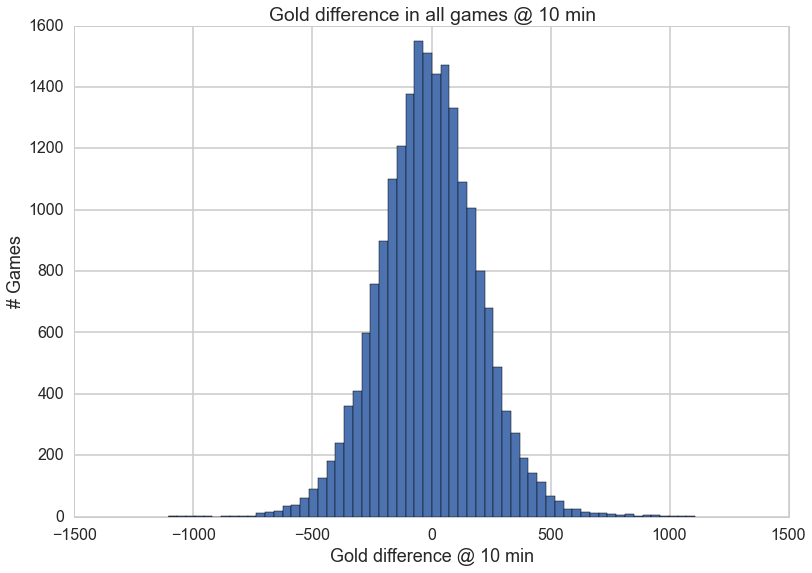

In [548]:
#all games
plt.hist(np.array(df1['diffgpm10']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference @ 10 min', fontsize = 18)
plt.title('Gold difference in all games @ 10 min')

Gold difference seems to be pretty normally distributed, without telling us much why it's so important, so let's split it by winning teams to see why our classifier found it to be so important.

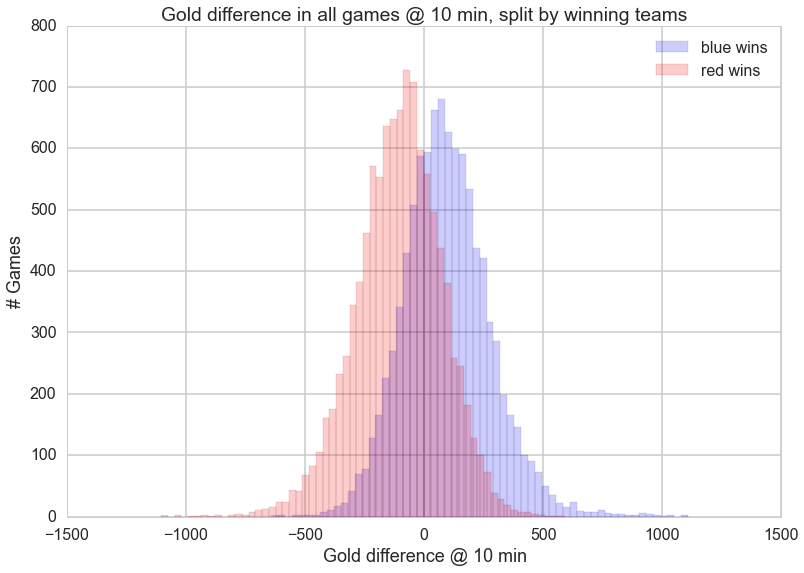

In [549]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffgpm10']), bins = 60, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffgpm10']), bins = 60, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,800))
plt.xlabel('Gold difference @ 10 min', fontsize = 18)
plt.title('Gold difference in all games @ 10 min, split by winning teams')
plt.legend()

Now we can we see the importance?

**Diff in cs @ 10 min**

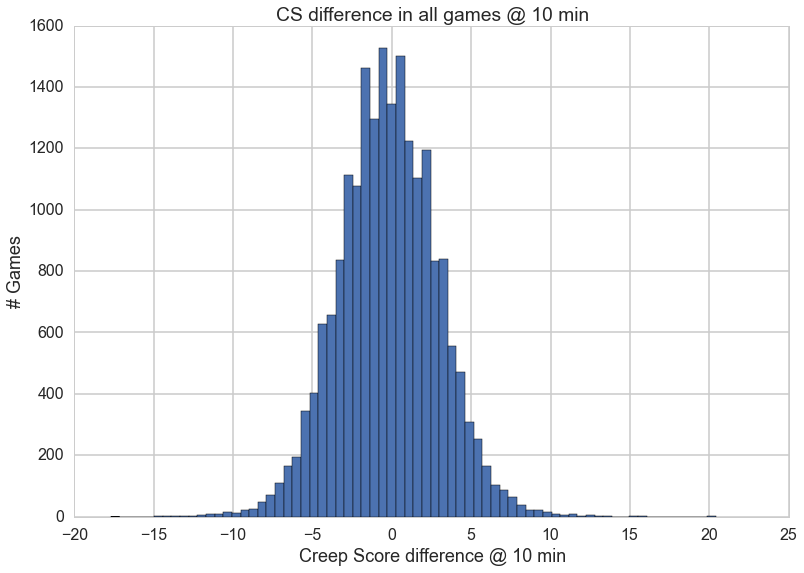

In [550]:
#all games
plt.hist(np.array(df1['diffcs10']), bins = 70)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Creep Score difference @ 10 min', fontsize = 18)
plt.title('CS difference in all games @ 10 min')

Again this doesn't really show us much, so let's look at it split into winning teams.

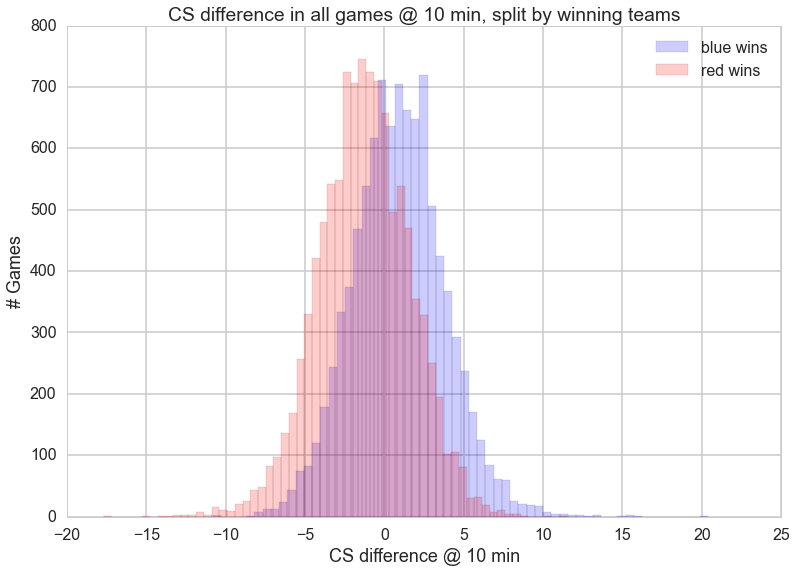

In [551]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffcs10']), bins = 60, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffcs10']), bins = 60, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,800))
plt.xlabel('CS difference @ 10 min', fontsize = 18)
plt.title('CS difference in all games @ 10 min, split by winning teams')
plt.legend()

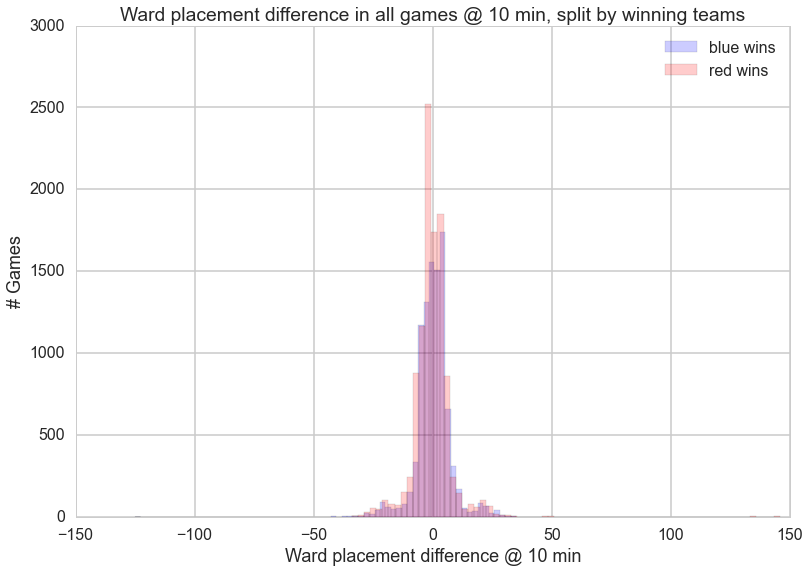

In [554]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffwardp10']), bins = 70, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffwardp10']), bins = 70, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Ward placement difference @ 10 min', fontsize = 18)
plt.title('Ward placement difference in all games @ 10 min, split by winning teams')
plt.legend()

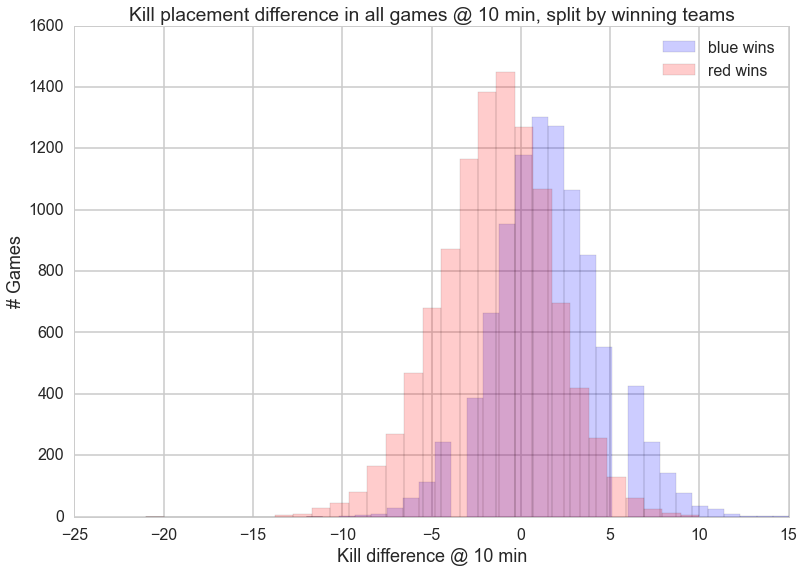

In [555]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffkill10']), bins = 30, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffkill10']), bins = 30, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 10 min', fontsize = 18)
plt.title('Kill placement difference in all games @ 10 min, split by winning teams')
plt.legend()

Let's look at features that was not deemed to be important (not inhib or baron, since those would not have been obtained by 10 min), difference in turrets and first bloods.

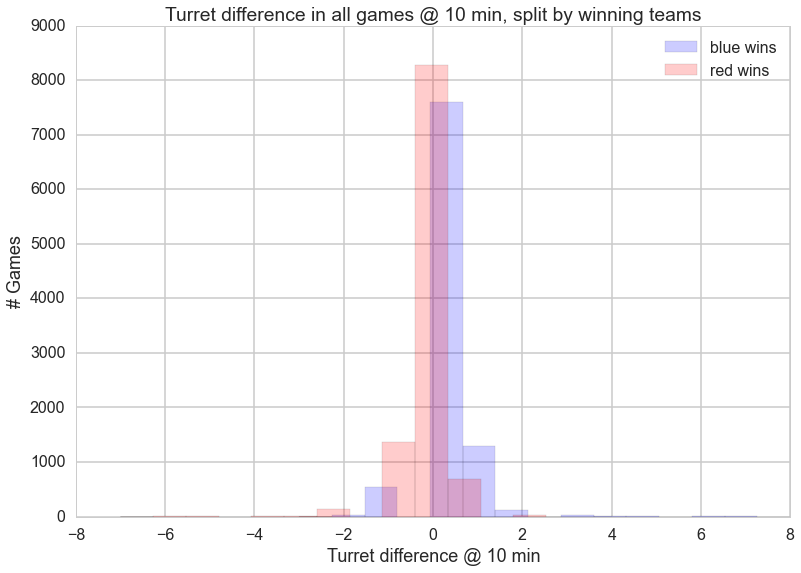

In [556]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffturret10']), bins = 15, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffturret10']), bins = 15, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Turret difference @ 10 min', fontsize = 18)
plt.title('Turret difference in all games @ 10 min, split by winning teams')
plt.legend()

So yeah this shit really isn't helpful. What about first blood?

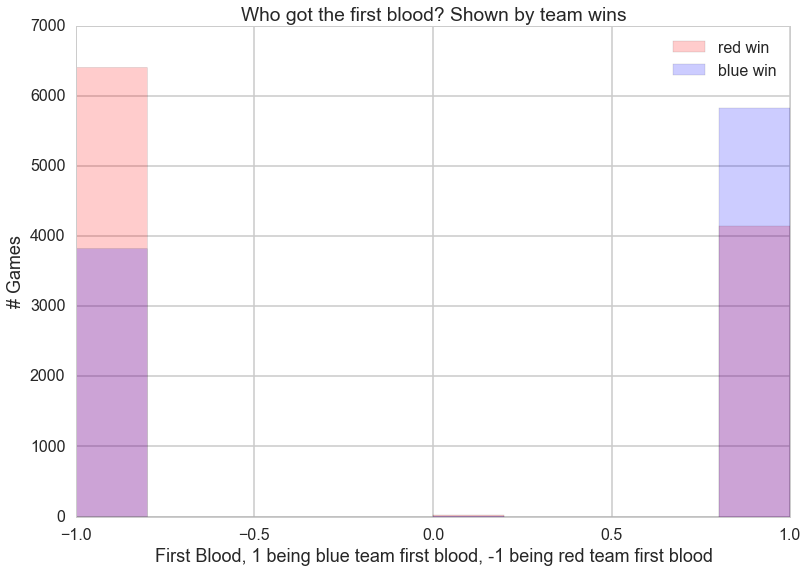

In [557]:
#all games, shown by team wins
plt.hist(np.array(redwins1['fb10l']), color = 'r', alpha = 0.2, label = "red win")
plt.hist(np.array(bluewins1['fb10l']), color = 'b', alpha = 0.2, label = "blue win")
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Blood, 1 being blue team first blood, -1 being red team first blood', fontsize = 18)
plt.title('Who got the first blood? Shown by team wins')
plt.legend()

Also not helpful 

<span style="font-size:1.3em">20 min mark</span>

In [507]:
#new Random forest classifier for 20 min
newForest2 = RandomForestClassifier()

In [508]:
#20 min variables to test
lcols2 = list(df2.columns.values)
#win is the response we want to test for
lcols2.remove('win')
lcols2

['diffbaron20',
 'diffcs20',
 'diffdrag20',
 'diffgpm20',
 'diffinhib20',
 'diffkill20',
 'diffturret20',
 'diffwardk20',
 'diffwardp20',
 'fb20l']

In [513]:
itrain3, itest3 = train_test_split(xrange(df2.shape[0]), train_size=0.75)

mask=np.ones(df2.shape[0], dtype='int')
mask[itrain3]=1
mask[itest3]=0
mask = (mask==1)
mask=np.ones(df2.shape[0], dtype='int')
mask[itrain3]=1
mask[itest3]=0
mask = (mask==1)

In [514]:
#We want a lot of trees 
parameters = {"n_estimators": range(1, 100)}
##We use the same mask values from the previous part since 1) the matches are the same, just different data and
##2) we want the same training and test matchids when doing do_classify
newForest2, Xtrain2, ytrain2, Xtest2, ytest2 = do_classify(newForest2, parameters, 
                                                       df2, lcols2, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 81} 0.801595926189 [mean: 0.73482, std: 0.00294, params: {'n_estimators': 1}, mean: 0.69850, std: 0.01109, params: {'n_estimators': 2}, mean: 0.76384, std: 0.00970, params: {'n_estimators': 3}, mean: 0.74705, std: 0.00747, params: {'n_estimators': 4}, mean: 0.77561, std: 0.00751, params: {'n_estimators': 5}, mean: 0.76532, std: 0.01137, params: {'n_estimators': 6}, mean: 0.78684, std: 0.00547, params: {'n_estimators': 7}, mean: 0.77285, std: 0.00792, params: {'n_estimators': 8}, mean: 0.78241, std: 0.00896, params: {'n_estimators': 9}, mean: 0.77835, std: 0.00755, params: {'n_estimators': 10}, mean: 0.78781, std: 0.00536, params: {'n_estimators': 11}, mean: 0.78354, std: 0.00804, params: {'n_estimators': 12}, mean: 0.79087, std: 0.00615, params: {'n_estimators': 13}, mean: 0.78592, std: 0.00797, params: {'n_estimators': 14}, mean: 0.78759, std: 0.00576, params: {'n_estimators': 15}, mean: 0.78622, std: 0.00972, params: {'n_estimators': 16}, mean: 0.78938, std: 0.0

In [515]:
#Optimized is 81 trees
newForest2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [516]:
#get importances at 20 min
imp2 = newForest2.feature_importances_

In [517]:
imp2_sort, lcols2_sort = zip(*sorted(zip(imp2, lcols2)))

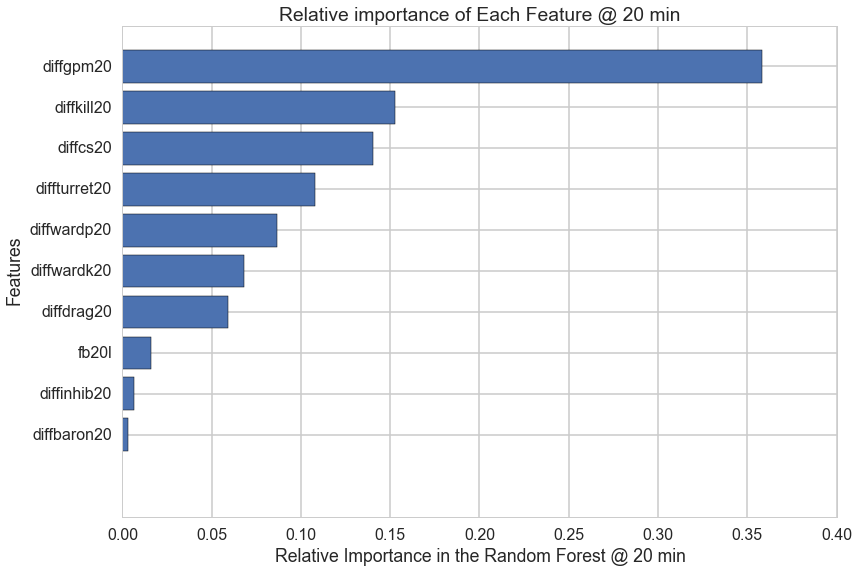

In [518]:
plt.barh(range(len(lcols2_sort)),imp2_sort,align='center')
plt.yticks(range(len(lcols2_sort)),lcols2_sort)
plt.xlabel('Relative Importance in the Random Forest @ 20 min')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature @ 20 min')
plt.show()

In [558]:
#spliting into blue and red wins to help us visualize
bluewins2 = df2.query('win == True')
redwins2 = df2.query('win == False')

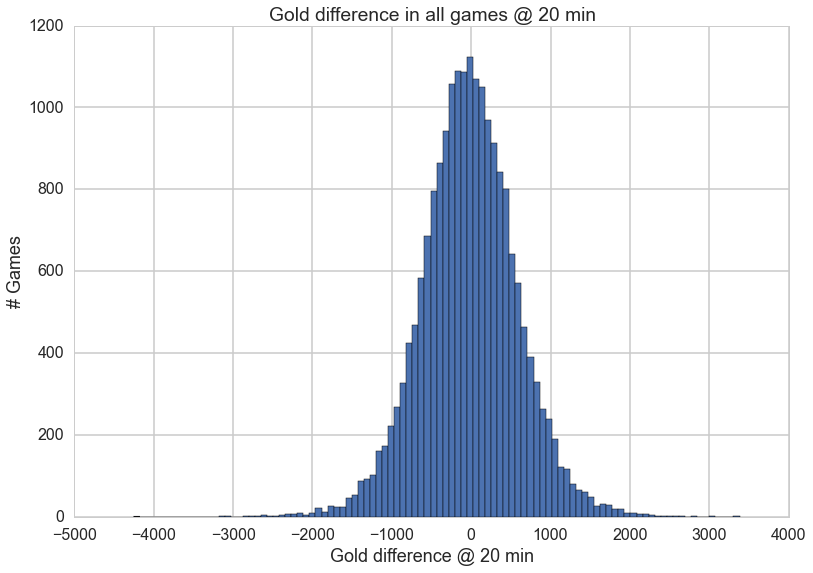

In [567]:
#all games
plt.hist(np.array(df2['diffgpm20']), bins = 100)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference @ 20 min', fontsize = 18)
plt.title('Gold difference in all games @ 20 min')

Interesting...

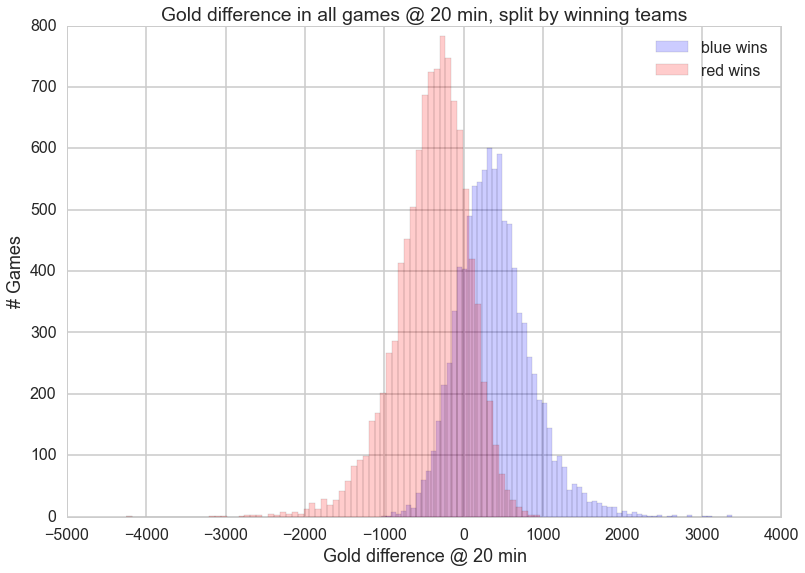

In [569]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffgpm20']), bins = 70, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffgpm20']), bins = 70, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,800))
plt.xlabel('Gold difference @ 20 min', fontsize = 18)
plt.title('Gold difference in all games @ 20 min, split by winning teams')
plt.legend()

There's a spike of games in the middle at 0 gold difference at 20 min'

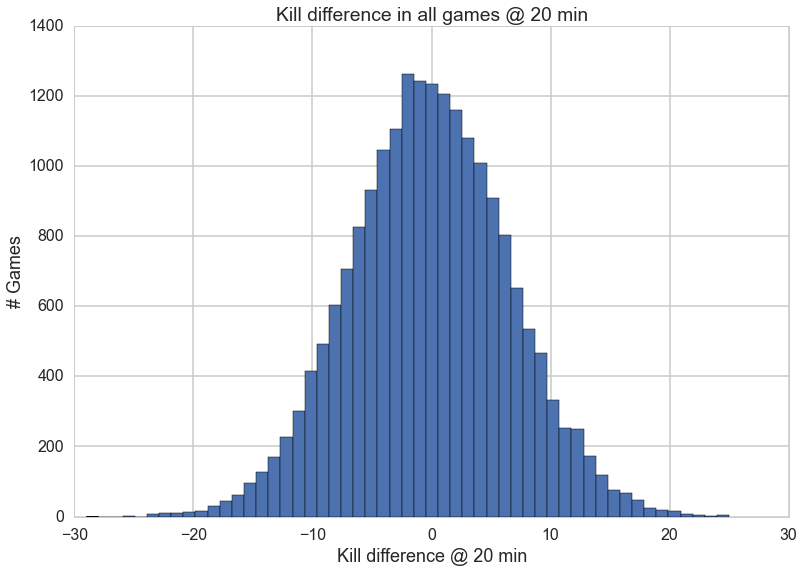

In [570]:
#all games
plt.hist(np.array(df2['diffkill20']), bins = 53)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 20 min', fontsize = 18)
plt.title('Kill difference in all games @ 20 min')

Not bi-modal?

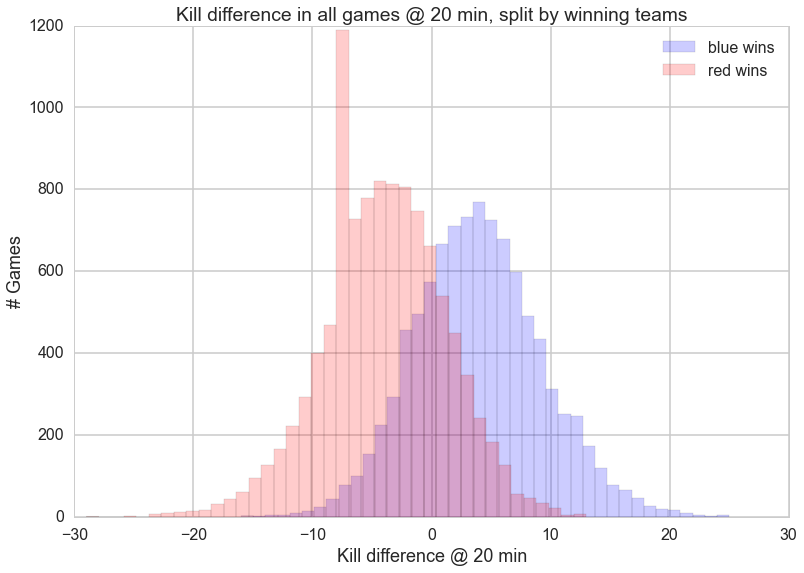

In [572]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffkill20']), bins = 40, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffkill20']), bins = 40, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 20 min', fontsize = 18)
plt.title('Kill difference in all games @ 20 min, split by winning teams')
plt.legend()

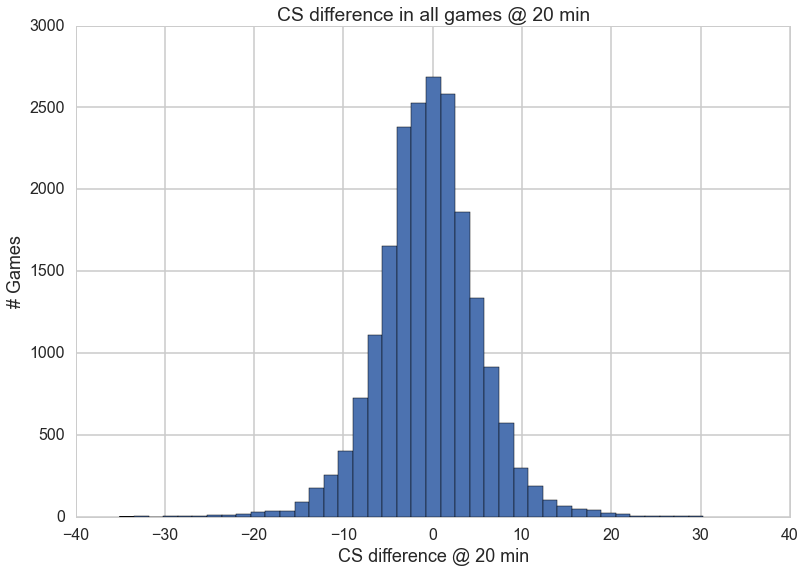

In [575]:
#all games
plt.hist(np.array(df2['diffcs20']), bins = 40)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('CS difference @ 20 min', fontsize = 18)
plt.title('CS difference in all games @ 20 min')

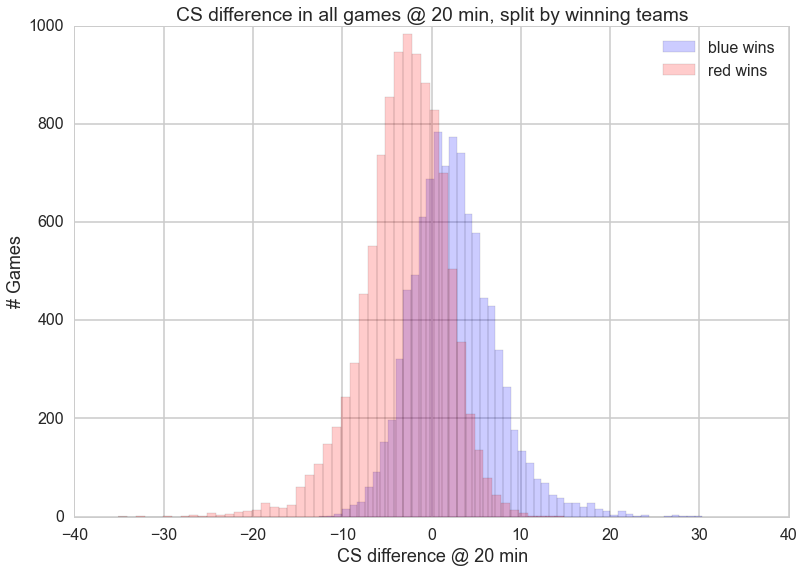

In [576]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffcs20']), bins = 50, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffcs20']), bins = 50, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('CS difference @ 20 min', fontsize = 18)
plt.title('CS difference in all games @ 20 min, split by winning teams')
plt.legend()

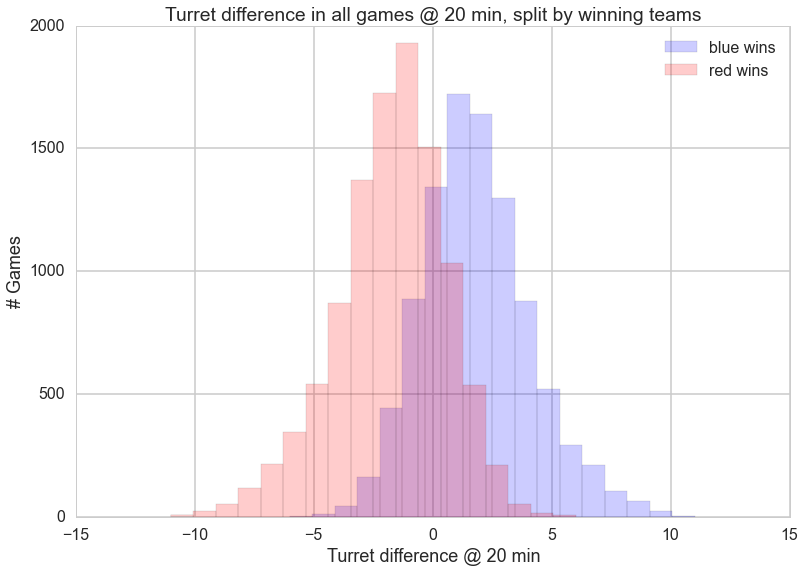

In [577]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffturret20']), bins = 18, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffturret20']), bins = 18, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Turret difference @ 20 min', fontsize = 18)
plt.title('Turret difference in all games @ 20 min, split by winning teams')
plt.legend()

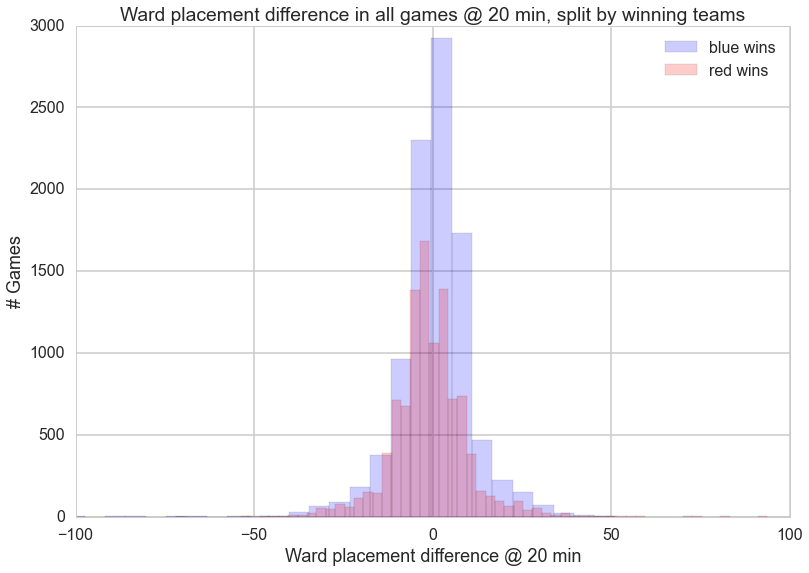

In [578]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffwardp20']), bins = 200, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffwardp20']), bins = 200, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlim((-100,100))
plt.xlabel('Ward placement difference @ 20 min', fontsize = 18)
plt.title('Ward placement difference in all games @ 20 min, split by winning teams')
plt.legend()

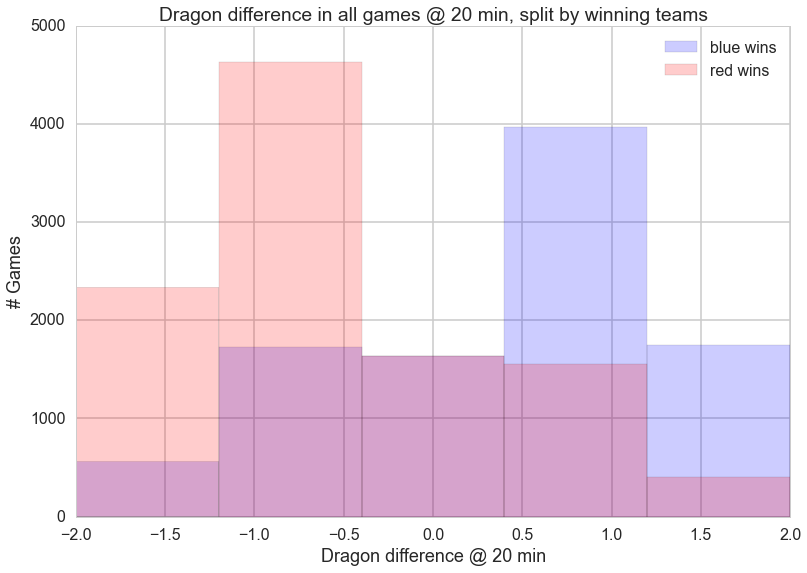

In [579]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffdrag20']), bins = 5, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffdrag20']), bins = 5, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Dragon difference @ 20 min', fontsize = 18)
plt.title('Dragon difference in all games @ 20 min, split by winning teams')
plt.legend()

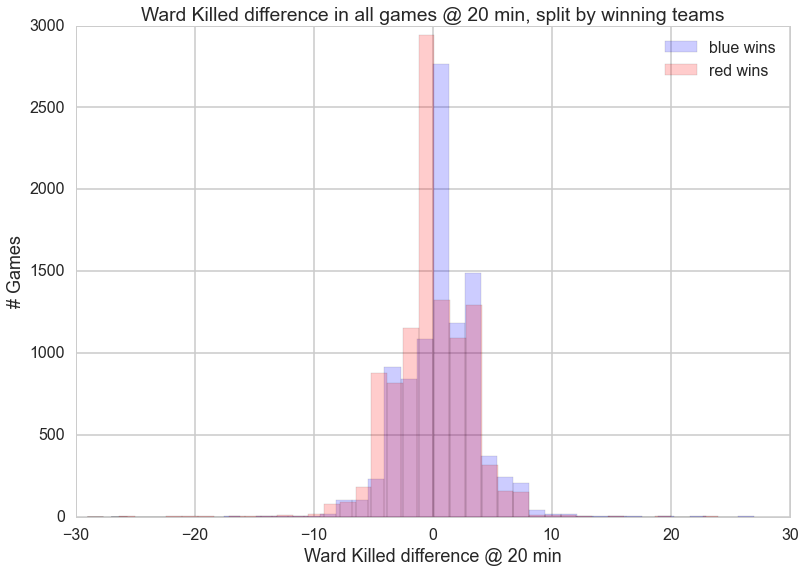

In [580]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffwardk20']), bins = 40, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffwardk20']), bins = 40, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Ward Killed difference @ 20 min', fontsize = 18)
plt.title('Ward Killed difference in all games @ 20 min, split by winning teams')
plt.legend()

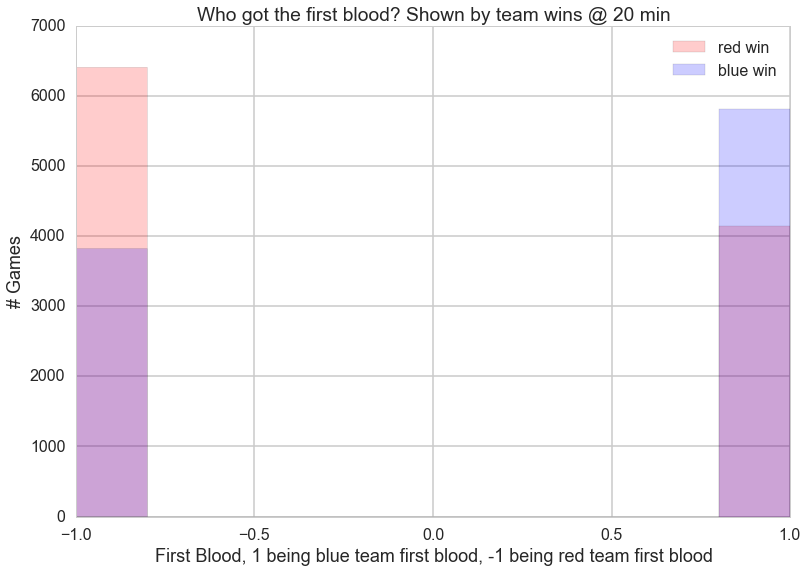

In [582]:
#all games, shown by team wins
plt.hist(np.array(redwins2['fb20l']), color = 'r', alpha = 0.2, label = "red win")
plt.hist(np.array(bluewins2['fb20l']), color = 'b', alpha = 0.2, label = "blue win")
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Blood, 1 being blue team first blood, -1 being red team first blood', fontsize = 18)
plt.title('Who got the first blood? Shown by team wins @ 20 min')
plt.legend()

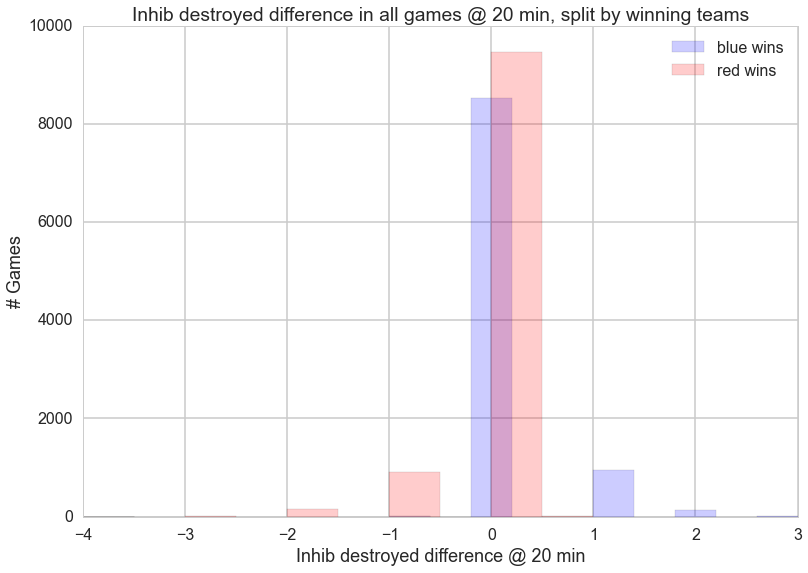

In [583]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffinhib20']), bins = 10, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffinhib20']), bins = 10, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Inhib destroyed difference @ 20 min', fontsize = 18)
plt.title('Inhib destroyed difference in all games @ 20 min, split by winning teams')
plt.legend()

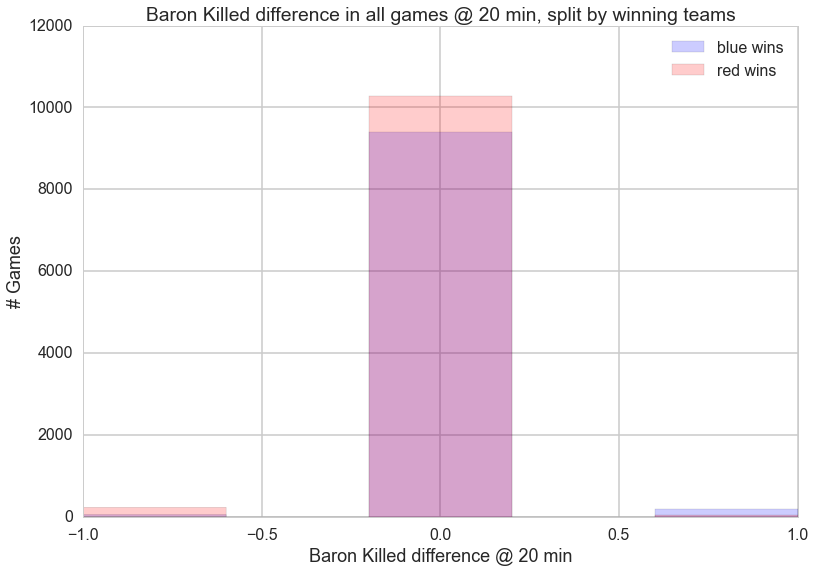

In [584]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffbaron20']), bins = 5, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffbaron20']), bins = 5, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Baron Killed difference @ 20 min', fontsize = 18)
plt.title('Baron Killed difference in all games @ 20 min, split by winning teams')
plt.legend()

30 min mark

In [533]:
#new Random forest classifier for 30 min
newForest3 = RandomForestClassifier()

In [534]:
#30 min variables to test
lcols3 = list(df3.columns.values)
#win is the response we want to test for
lcols3.remove('win')
lcols3

['diffbaron30',
 'diffcs30',
 'diffdrag30',
 'diffgpm30',
 'diffinhib30',
 'diffkill30',
 'diffturret30',
 'diffwardk30',
 'diffwardp30',
 'fb30l']

In [535]:
itrain4, itest4 = train_test_split(xrange(df3.shape[0]), train_size=0.75)

mask=np.ones(df3.shape[0], dtype='int')
mask[itrain4]=1
mask[itest4]=0
mask = (mask==1)
mask=np.ones(df3.shape[0], dtype='int')
mask[itrain4]=1
mask[itest4]=0
mask = (mask==1)

In [536]:
#We want a lot of trees 
parameters = {"n_estimators": range(1, 100)}
##We use the same mask values from the previous part since 1) the matches are the same, just different data and
##2) we want the same training and test matchids when doing do_classify
newForest3, Xtrain3, ytrain3, Xtest3, ytest3 = do_classify(newForest3, parameters, 
                                                       df3, lcols3, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 80} 0.88191496376 [mean: 0.83152, std: 0.01110, params: {'n_estimators': 1}, mean: 0.81719, std: 0.01030, params: {'n_estimators': 2}, mean: 0.85711, std: 0.01101, params: {'n_estimators': 3}, mean: 0.85186, std: 0.00982, params: {'n_estimators': 4}, mean: 0.86283, std: 0.01059, params: {'n_estimators': 5}, mean: 0.85963, std: 0.00903, params: {'n_estimators': 6}, mean: 0.86670, std: 0.01079, params: {'n_estimators': 7}, mean: 0.86508, std: 0.01014, params: {'n_estimators': 8}, mean: 0.87149, std: 0.00747, params: {'n_estimators': 9}, mean: 0.87324, std: 0.00836, params: {'n_estimators': 10}, mean: 0.87255, std: 0.00544, params: {'n_estimators': 11}, mean: 0.87327, std: 0.00949, params: {'n_estimators': 12}, mean: 0.87331, std: 0.00609, params: {'n_estimators': 13}, mean: 0.87266, std: 0.00818, params: {'n_estimators': 14}, mean: 0.87510, std: 0.01007, params: {'n_estimators': 15}, mean: 0.87416, std: 0.00722, params: {'n_estimators': 16}, mean: 0.87700, std: 0.00

In [537]:
#Optimized is 80 trees
newForest3

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [538]:
#get importances at 30 min
imp3 = newForest3.feature_importances_

In [539]:
imp3_sort, lcols3_sort = zip(*sorted(zip(imp3, lcols3)))

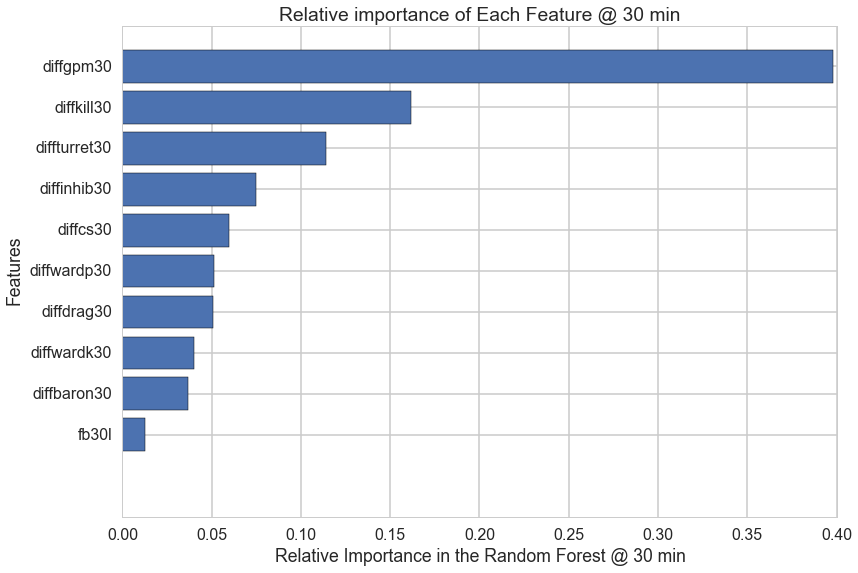

In [540]:
plt.barh(range(len(lcols3_sort)),imp3_sort,align='center')
plt.yticks(range(len(lcols3_sort)),lcols3_sort)
plt.xlabel('Relative Importance in the Random Forest @ 30 min')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature @ 30 min')
plt.show()

In [585]:
#spliting into blue and red wins to help us visualize
bluewins3 = df3.query('win == True')
redwins3 = df3.query('win == False')

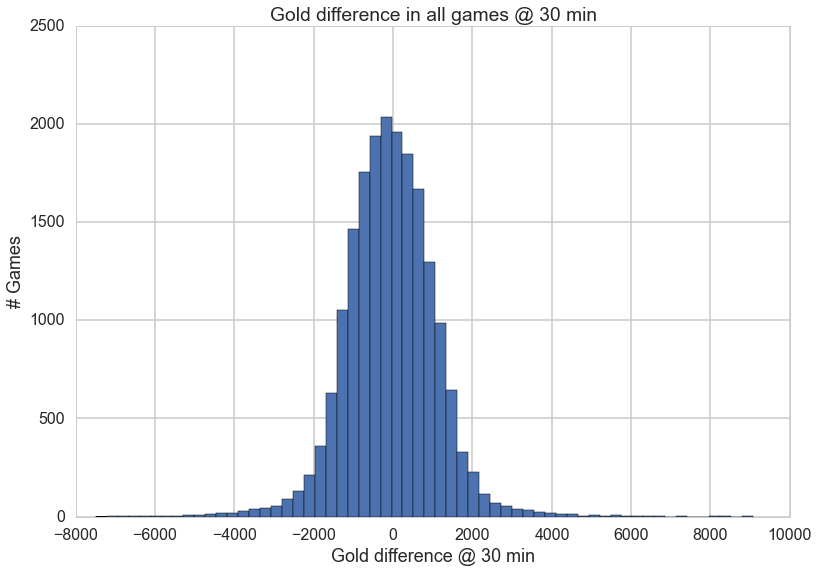

In [588]:
#all games
plt.hist(np.array(df3['diffgpm30']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference @ 30 min', fontsize = 18)
plt.title('Gold difference in all games @ 30 min')

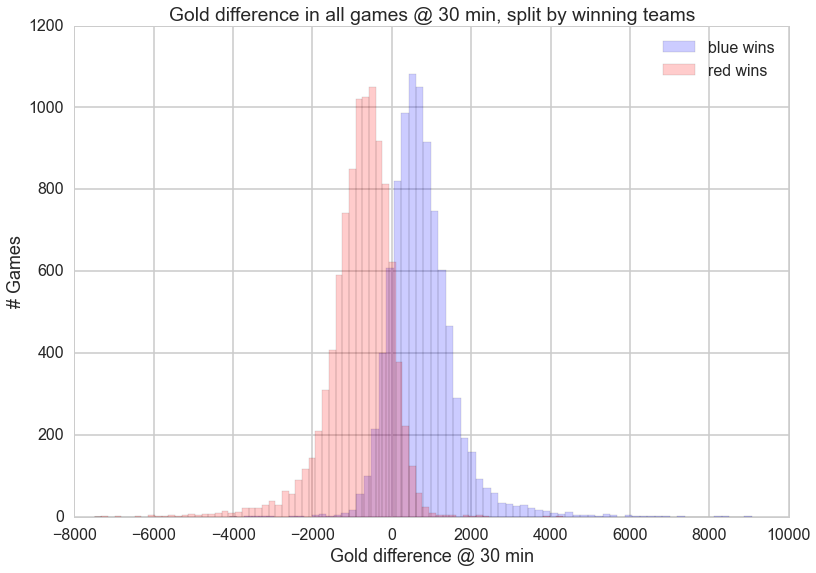

In [594]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffgpm30']), bins = 70, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffgpm30']), bins = 70, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference @ 30 min', fontsize = 18)
plt.title('Gold difference in all games @ 30 min, split by winning teams')
plt.legend()

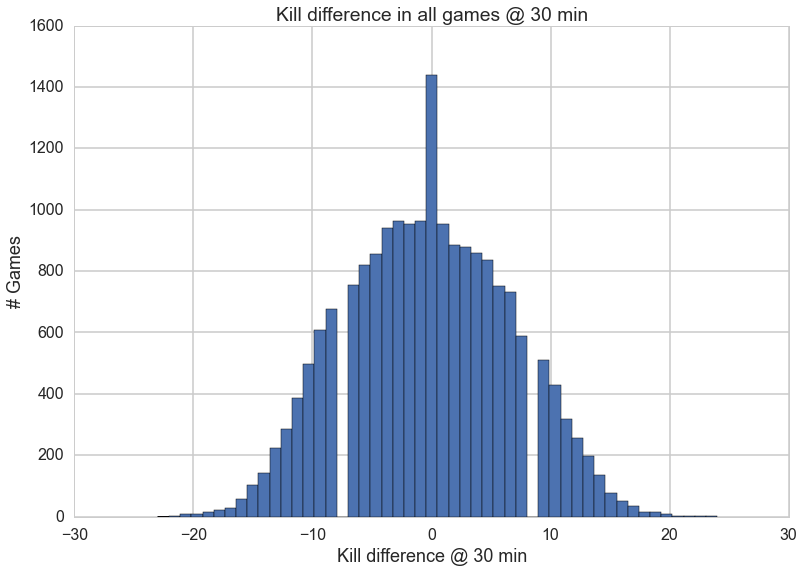

In [595]:
#all games
plt.hist(np.array(df3['diffkill30']), bins = 50)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 30 min', fontsize = 18)
plt.title('Kill difference in all games @ 30 min')

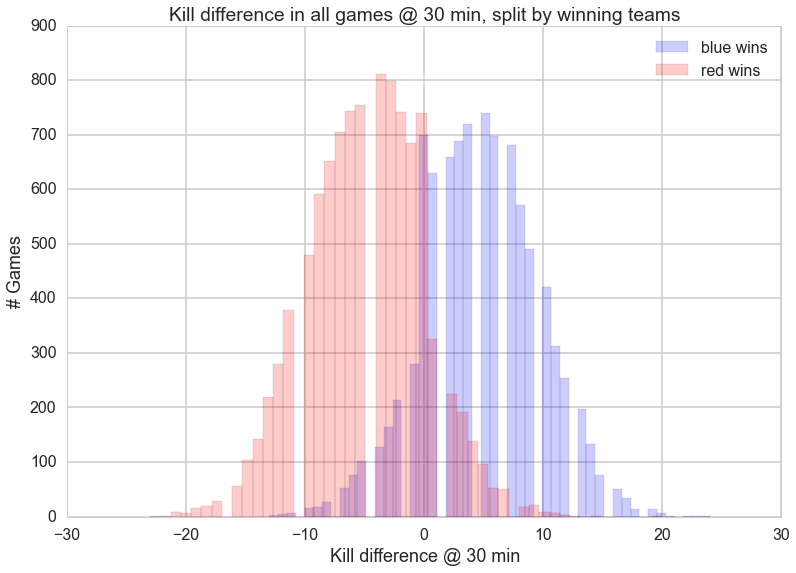

In [596]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffkill30']), bins = 50, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffkill30']), bins = 50, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 30 min', fontsize = 18)
plt.title('Kill difference in all games @ 30 min, split by winning teams')
plt.legend()

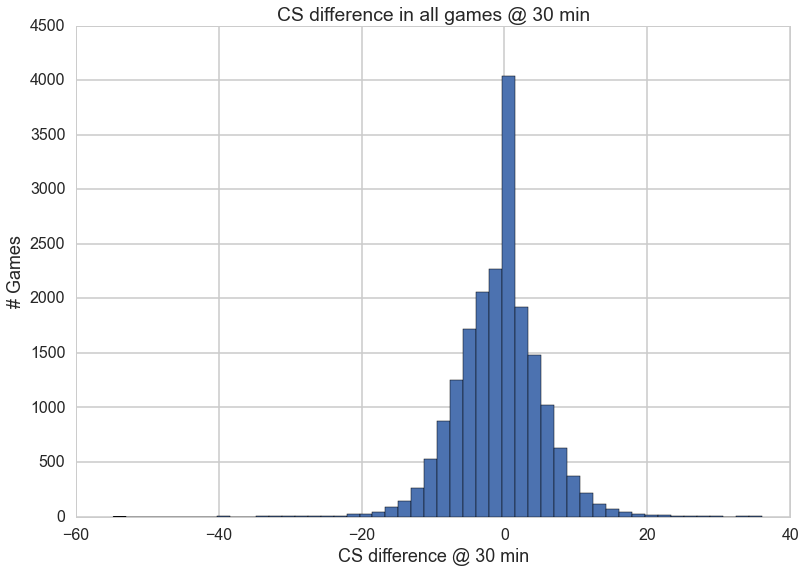

In [597]:
#all games
plt.hist(np.array(df3['diffcs30']), bins = 50)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('CS difference @ 30 min', fontsize = 18)
plt.title('CS difference in all games @ 30 min')

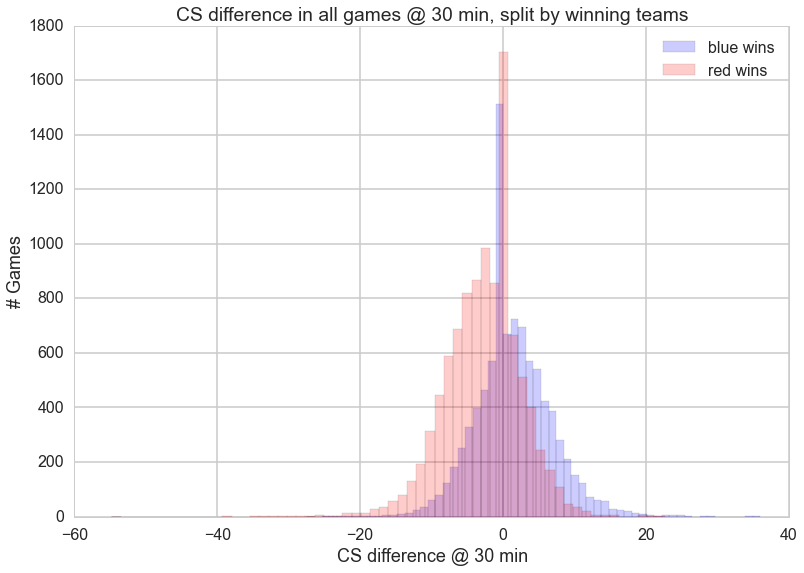

In [598]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffcs30']), bins = 60, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffcs30']), bins = 60, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('CS difference @ 30 min', fontsize = 18)
plt.title('CS difference in all games @ 30 min, split by winning teams')
plt.legend()

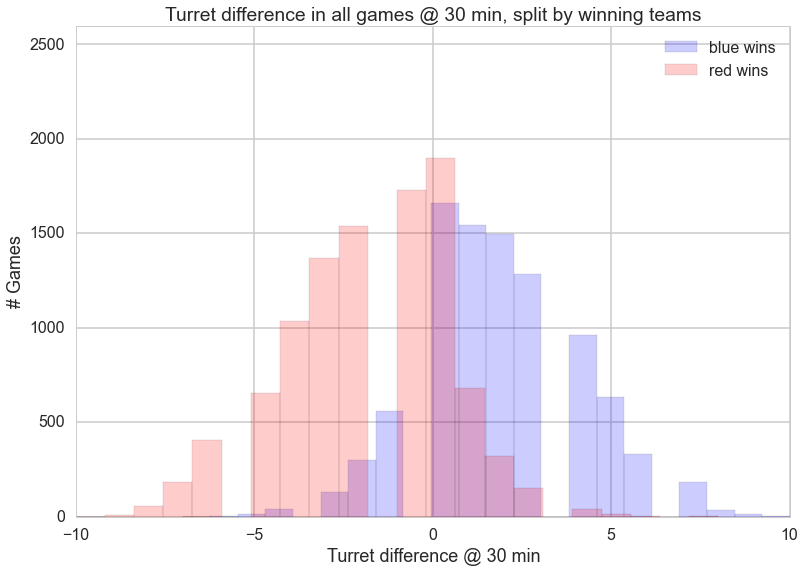

In [599]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffturret30']), bins = 22, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffturret30']), bins = 22, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,2600))
plt.xlabel('Turret difference @ 30 min', fontsize = 18)
plt.title('Turret difference in all games @ 30 min, split by winning teams')
plt.legend()

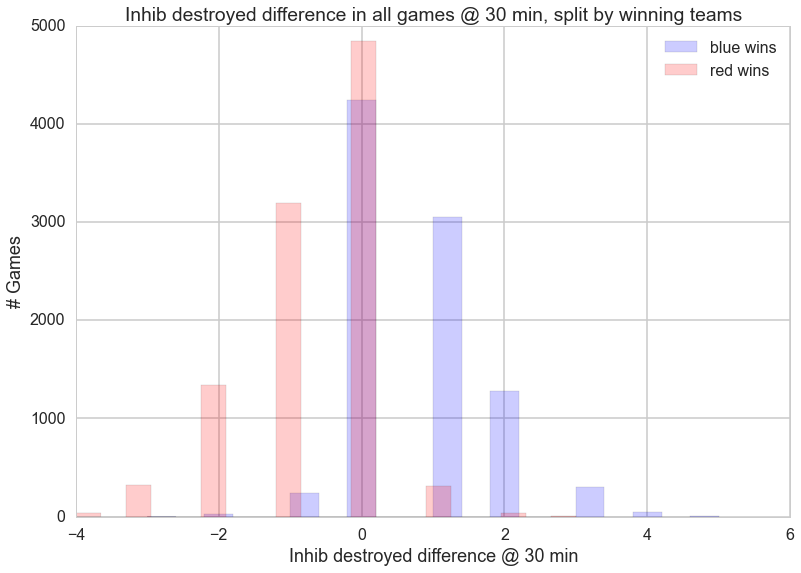

In [600]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffinhib30']), bins = 20, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffinhib30']), bins = 20, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Inhib destroyed difference @ 30 min', fontsize = 18)
plt.title('Inhib destroyed difference in all games @ 30 min, split by winning teams')
plt.legend()

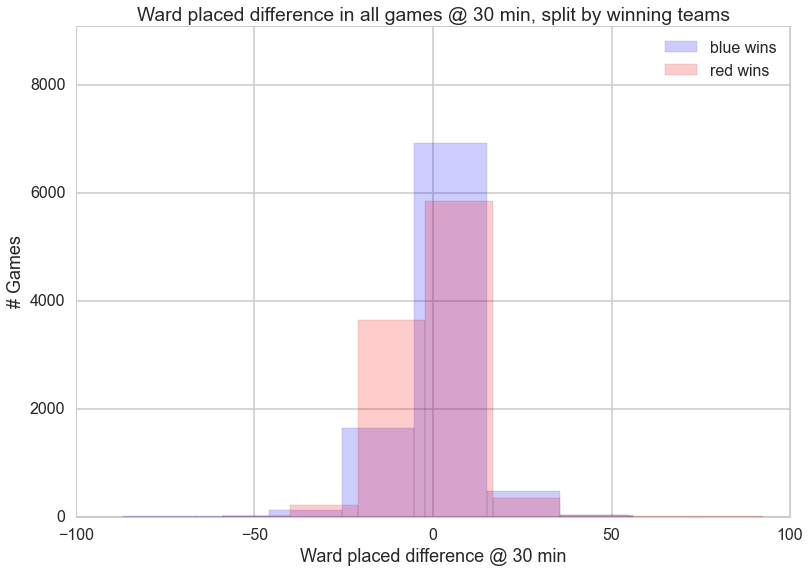

In [601]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffwardp30']), bins = 50, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffwardp30']), bins = 30, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlim((-100,100))
plt.ylim((0,9100))
plt.xlabel('Ward placed difference @ 30 min', fontsize = 18)
plt.title('Ward placed difference in all games @ 30 min, split by winning teams')
plt.legend()

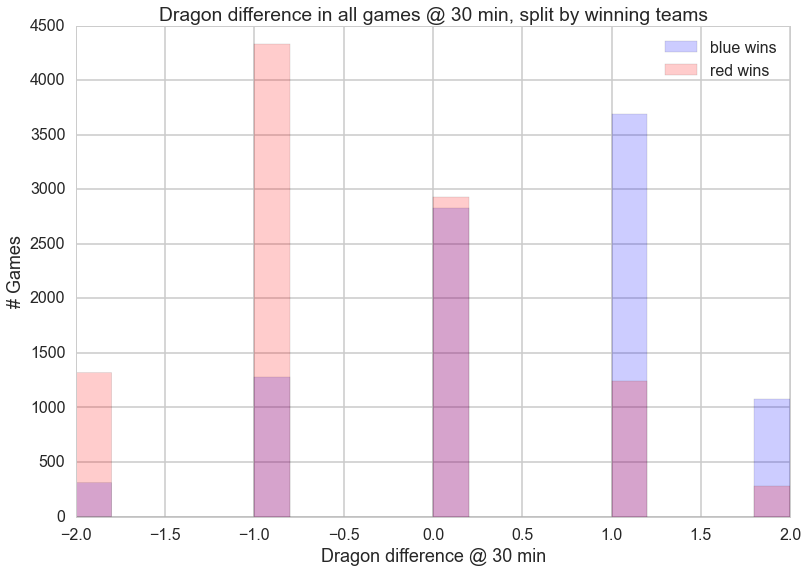

In [602]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffdrag30']), bins = 20, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffdrag30']), bins = 20, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Dragon difference @ 30 min', fontsize = 18)
plt.title('Dragon difference in all games @ 30 min, split by winning teams')
plt.legend()

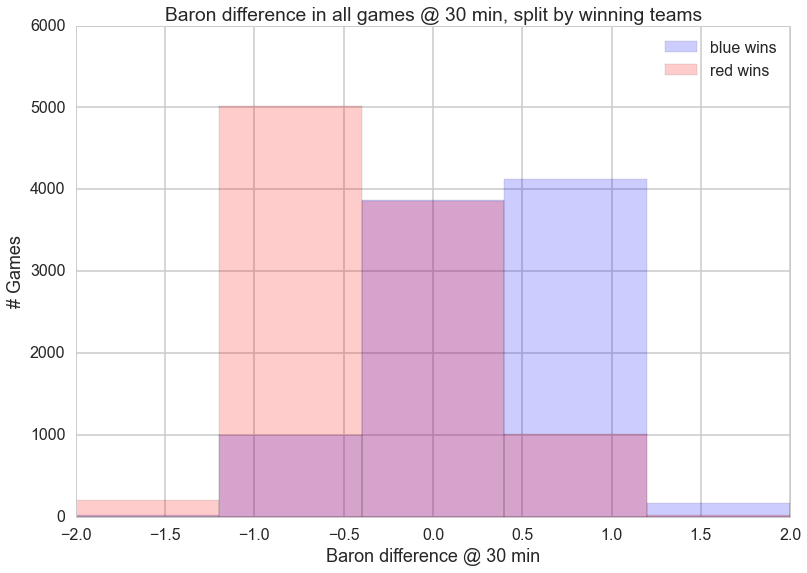

In [603]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffbaron30']), bins = 5, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffbaron30']), bins = 5, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Baron difference @ 30 min', fontsize = 18)
plt.title('Baron difference in all games @ 30 min, split by winning teams')
plt.legend()

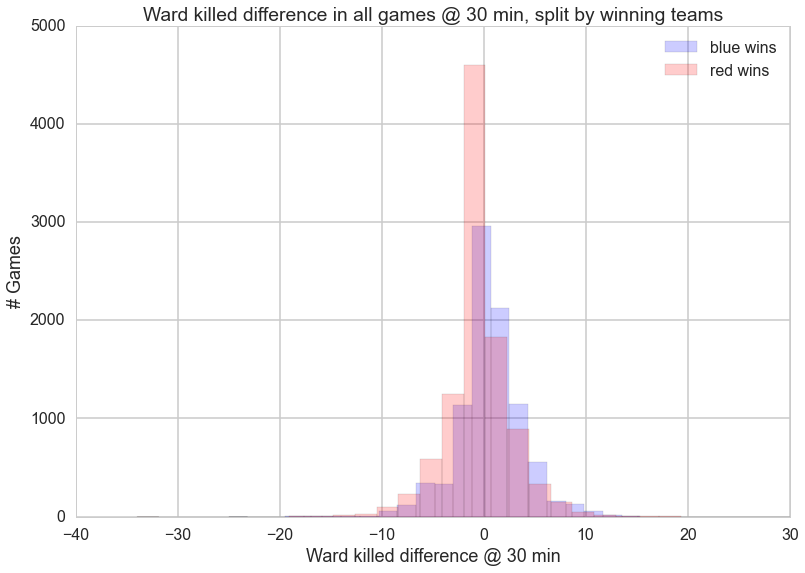

In [604]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffwardk30']), bins = 30, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffwardk30']), bins = 30, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Ward killed difference @ 30 min', fontsize = 18)
plt.title('Ward killed difference in all games @ 30 min, split by winning teams')
plt.legend()

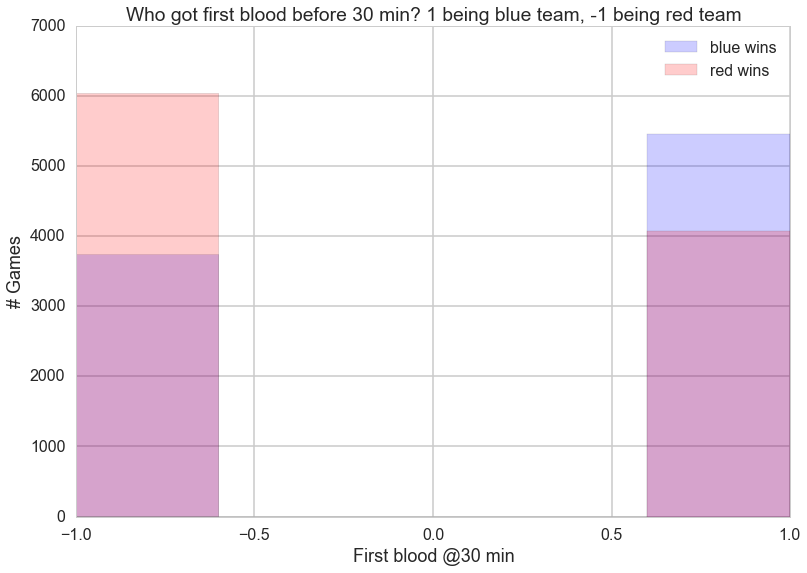

In [605]:
#all games, split by winning team
plt.hist(np.array(bluewins3['fb30l']), bins = 5, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['fb30l']), bins = 5, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First blood @30 min', fontsize = 18)
plt.title('Who got first blood before 30 min? 1 being blue team, -1 being red team')
plt.legend()

Random forest the entire data set

In [309]:
allcols = list(df.columns.values)

In [311]:
allcols.remove('win')
allcols.remove('matchid')

In [312]:
allcols

['diffbaron10',
 'diffbaron20',
 'diffbaron30',
 'diffcs10',
 'diffcs20',
 'diffcs30',
 'diffdrag10',
 'diffdrag20',
 'diffdrag30',
 'diffgpm10',
 'diffgpm20',
 'diffgpm30',
 'diffinhib10',
 'diffinhib20',
 'diffinhib30',
 'diffkill10',
 'diffkill20',
 'diffkill30',
 'diffturret10',
 'diffturret20',
 'diffturret30',
 'diffwardk10',
 'diffwardk20',
 'diffwardk30',
 'diffwardp10',
 'diffwardp20',
 'diffwardp30',
 'fb10l',
 'fb20l',
 'fb30l']

In [307]:
wholeForest = RandomForestClassifier()

In [313]:
#We want a lot of trees 
parameters = {"n_estimators": range(1, 100)}
##We use the same mask values from the previous part since 1) the matches are the same, just different data and
##2) we want the same training and test matchids when doing do_classify
wholeForest, Xtrainx, ytrainx, Xtestx, ytestx = do_classify(wholeForest, parameters, 
                                                       df, allcols, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 97} 0.906648274359 [mean: 0.85346, std: 0.00670, params: {'n_estimators': 1}, mean: 0.83952, std: 0.01018, params: {'n_estimators': 2}, mean: 0.87823, std: 0.00512, params: {'n_estimators': 3}, mean: 0.87081, std: 0.00847, params: {'n_estimators': 4}, mean: 0.88944, std: 0.00593, params: {'n_estimators': 5}, mean: 0.88410, std: 0.00559, params: {'n_estimators': 6}, mean: 0.89406, std: 0.00493, params: {'n_estimators': 7}, mean: 0.89135, std: 0.00728, params: {'n_estimators': 8}, mean: 0.89519, std: 0.00438, params: {'n_estimators': 9}, mean: 0.89434, std: 0.00815, params: {'n_estimators': 10}, mean: 0.89721, std: 0.00512, params: {'n_estimators': 11}, mean: 0.89771, std: 0.00422, params: {'n_estimators': 12}, mean: 0.89645, std: 0.00175, params: {'n_estimators': 13}, mean: 0.89750, std: 0.00764, params: {'n_estimators': 14}, mean: 0.89944, std: 0.00525, params: {'n_estimators': 15}, mean: 0.89835, std: 0.00668, params: {'n_estimators': 16}, mean: 0.89989, std: 0.0

In [314]:
#Optimized is 97 trees
wholeForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=97, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [315]:
#get importances
allimp = wholeForest.feature_importances_

In [316]:
allimp_sort, allcols_sort = zip(*sorted(zip(allimp, allcols)))

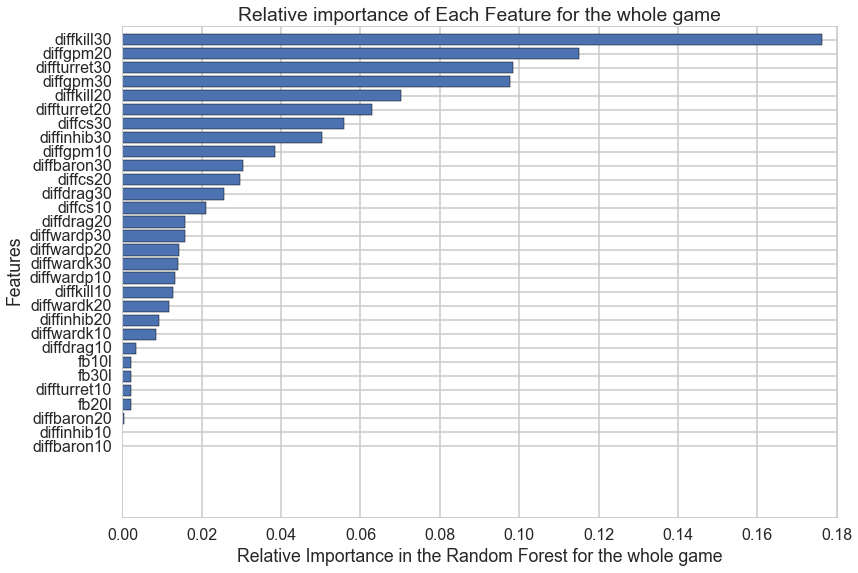

In [317]:
plt.barh(range(len(allcols_sort)),allimp_sort,align='center')
plt.yticks(range(len(allcols_sort)),allcols_sort)
plt.xlabel('Relative Importance in the Random Forest for the whole game')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature for the whole game')
plt.show()

Graphing the differing importances versus each other at different times

In [365]:
#creating a list of columns to set as x ticks
newcol = list(df1.columns.values)

In [367]:
#removing win because that's not an independent variable
newcol.remove('win')

In [369]:
newcol

['diffbaron10',
 'diffcs10',
 'diffdrag10',
 'diffgpm10',
 'diffinhib10',
 'diffkill10',
 'diffturret10',
 'diffwardk10',
 'diffwardp10',
 'fb10l']

In [370]:
#now we take out the 10 in the column names so it's just "diffkill", "diffcs", etc.
xtickcols = []
for col in newcol:
    ncol = col.replace("10", "")
    xtickcols.append(ncol) 

In [371]:
xtickcols

['diffbaron',
 'diffcs',
 'diffdrag',
 'diffgpm',
 'diffinhib',
 'diffkill',
 'diffturret',
 'diffwardk',
 'diffwardp',
 'fbl']

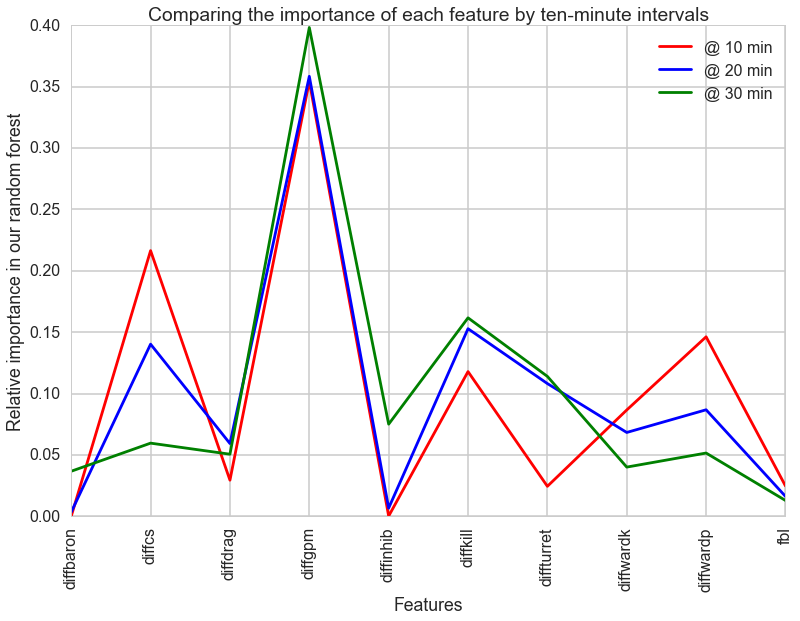

In [606]:
#Plotting the importances, color-coded by the ten-minute intervals
plt.plot(imp1, color = 'r', label = '@ 10 min')
plt.plot(imp2, color = 'b', label = '@ 20 min')
plt.plot(imp3, color = 'g', label = '@ 30 min')
plt.xticks(np.arange(len(xtickcols)))
#change each value to string just in case
x_tick_labels = [str(col) for col in xtickcols]
#set the x ticks to be the features
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
plt.ylabel("Relative importance in our random forest")
plt.xlabel("Features")
plt.title("Comparing the importance of each feature by ten-minute intervals")
plt.legend()

#Logistic Regression

did logistic regression on both dataframes (non-time interval and time interval one)

okay so i did logistic regression and the results were kind of weird - dragon as a powerful variable @ 10min, inhib/baron @ 20/30? Let's say we did this regression first and then 1) our intuition told us that this might be wrong and 2) logistic regression is more sensitive to collinearity and that's why we went to a new model? random forest?

In [377]:
from sklearn.linear_model import LogisticRegression

In [451]:
logdf = pd.read_csv('newdf.csv')
logdf.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win
0,1,819,155,17067,3,17703,18.144444,-1,5,0,True,False,True,True,False,True
1,1,-685,24,-23447,0,-11396,-20.117208,1,-7,1,True,False,True,False,False,False
2,-1,658,16,-5988,0,-11734,-21.416667,1,-3,1,False,True,True,False,True,False
3,-1,-339,-127,-9102,-2,-17661,-17.531349,1,-6,0,False,False,False,False,False,False
4,0,756,162,12505,0,11899,26.059524,0,3,3,False,False,False,True,True,True


In [455]:
columns = list(logdf.columns.values)

In [456]:
columns.remove('win')
columns

['diffbaron',
 'diffcc',
 'diffcs',
 'diffdmg',
 'diffdrag',
 'diffgold',
 'diffkda',
 'diffrange',
 'diffspree',
 'difftank',
 'fbaron',
 'fblood',
 'fdrag',
 'finhib',
 'fturret']

In [463]:
lasso = LogisticRegression(penalty = 'l1')
clflasso, Xtrainl, ytrainl, Xtestl, ytestl = do_classify(lasso, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},logdf,columns, 'win',1, mask = mask)

using mask
BEST {'C': 0.1} 0.9804504326 [mean: 0.97959, std: 0.00142, params: {'C': 0.001}, mean: 0.97953, std: 0.00151, params: {'C': 0.01}, mean: 0.98045, std: 0.00156, params: {'C': 0.1}, mean: 0.98032, std: 0.00183, params: {'C': 1.0}, mean: 0.98012, std: 0.00183, params: {'C': 10.0}, mean: 0.98025, std: 0.00183, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.98
[[2645   61]
 [  49 2293]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20223 but corresponding boolean dimension is 20189


In [465]:
#Getting the coefficients of each features
coef = list(clflasso.coef_[0])

In [466]:
print coef

[-0.31179134961664479, 3.1408817400953613e-05, -0.0061375218101635664, 9.0594567857217073e-06, -0.054479718950485312, 0.00063087265426519312, 0.021331261476895919, -0.0075058125295135829, -0.050675311277689102, 0.04316528819036753, -0.24504195030805145, -0.31603293762093371, 0.038738055556550792, 1.0821539383551289, 0.0]


In [467]:
coef_sort, logcols_sort = zip(*sorted(zip(coef, columns)))

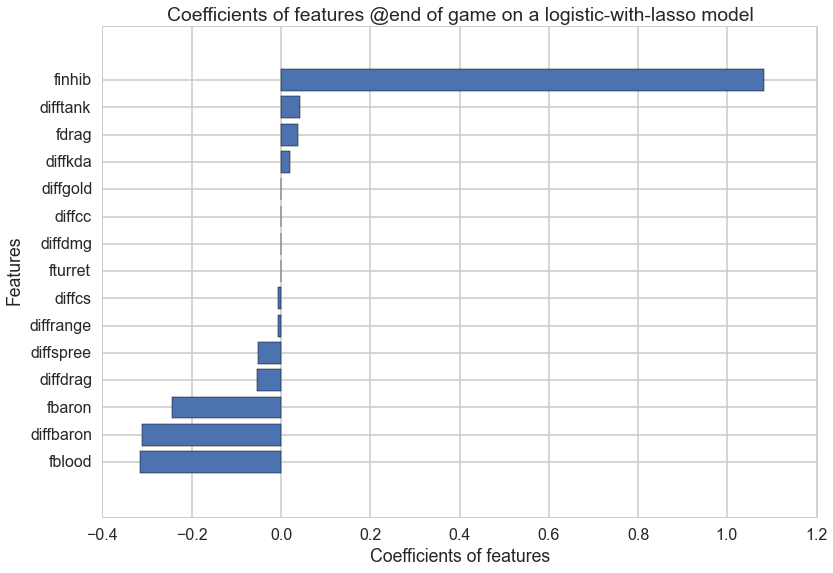

In [468]:
plt.barh(range(len(logcols_sort)), coef_sort,align='center')
plt.yticks(range(len(logcols_sort)),logcols_sort)
plt.xlabel('Coefficients of features')
plt.ylabel('Features')
plt.title('Coefficients of features @end of game on a logistic-with-lasso model')
plt.show()

10 min

In [607]:
df1.head()

,diffbaron10,diffcs10,diffdrag10,diffgpm10,diffinhib10,diffkill10,diffturret10,diffwardk10,diffwardp10,fb10l,win
0,0,4.3,0,199.6,0,2,0,0,-4,-1,True
1,0,2.3,1,-75.5,0,-3,-1,2,-4,-1,False
2,0,4.5,0,223.6,0,3,1,0,3,1,False
3,0,-2.9,0,-274.6,0,-6,0,0,0,-1,False
4,0,2.4,0,126.0,0,3,0,0,-6,-1,True


In [608]:
lcols1

['diffbaron10',
 'diffcs10',
 'diffdrag10',
 'diffgpm10',
 'diffinhib10',
 'diffkill10',
 'diffturret10',
 'diffwardk10',
 'diffwardp10',
 'fb10l']

In [609]:
lasso1 = LogisticRegression(penalty = 'l1')
clflog1, Xtrainlog1, ytrainlog1, Xtestlog1, ytestlog1 = do_classify(lasso1, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df1,lcols1, 'win',1, mask = mask)

using mask
BEST {'C': 0.1} 0.713890617438 [mean: 0.70877, std: 0.00550, params: {'C': 0.001}, mean: 0.71348, std: 0.00659, params: {'C': 0.01}, mean: 0.71389, std: 0.00607, params: {'C': 0.1}, mean: 0.71382, std: 0.00612, params: {'C': 1.0}, mean: 0.71320, std: 0.00636, params: {'C': 10.0}, mean: 0.71341, std: 0.00607, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.71
Accuracy on test data:     0.71
[[1854  662]
 [ 730 1576]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20214 but corresponding boolean dimension is 19285


In [610]:
#Getting the coefficients of each features
coef1 = list(clflog1.coef_[0])

In [611]:
print lcols1
print coef1

['diffbaron10', 'diffcs10', 'diffdrag10', 'diffgpm10', 'diffinhib10', 'diffkill10', 'diffturret10', 'diffwardk10', 'diffwardp10', 'fb10l']
[0.0, 0.089321808977006298, 0.25953749749418215, 0.0052154433896385863, 0.0, 0.034708174454210129, -0.19776488894838154, 0.0022325484348740634, 0.0070284996783284252, -0.020779779069608081]


In [612]:
coef1_sort, logcols1_sort = zip(*sorted(zip(coef1, lcols1)))

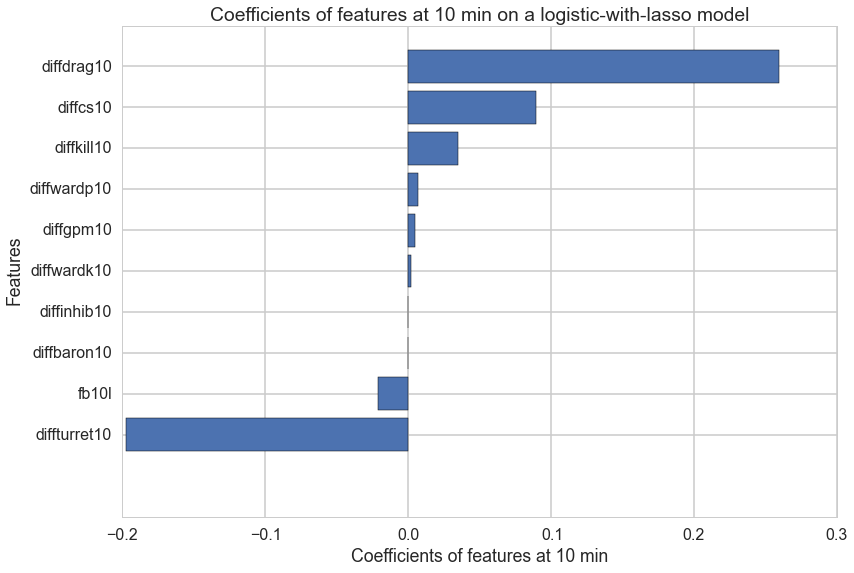

In [613]:
plt.barh(range(len(logcols1_sort)), coef1_sort,align='center')
plt.yticks(range(len(logcols1_sort)),logcols1_sort)
plt.xlabel('Coefficients of features at 10 min')
plt.ylabel('Features')
plt.title('Coefficients of features at 10 min on a logistic-with-lasso model')
plt.show()

20 min

In [614]:
lasso2 = LogisticRegression(penalty = 'l1')
clflog2, Xtrainlog2, ytrainlog2, Xtestlog2, ytestlog2 = do_classify(lasso2, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df2,lcols2, 'win',1, mask = mask)

using mask
BEST {'C': 100.0} 0.818294959552 [mean: 0.81021, std: 0.00949, params: {'C': 0.001}, mean: 0.81622, std: 0.00598, params: {'C': 0.01}, mean: 0.81747, std: 0.00661, params: {'C': 0.1}, mean: 0.81781, std: 0.00601, params: {'C': 1.0}, mean: 0.81802, std: 0.00582, params: {'C': 10.0}, mean: 0.81829, std: 0.00577, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.83
[[2118  413]
 [ 423 1868]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20189 but corresponding boolean dimension is 19285


In [615]:
#Getting the coefficients of each features
coef2 = list(clflog2.coef_[0])

In [616]:
print lcols2
print coef2

['diffbaron20', 'diffcs20', 'diffdrag20', 'diffgpm20', 'diffinhib20', 'diffkill20', 'diffturret20', 'diffwardk20', 'diffwardp20', 'fb20l']
[0.70756345905268614, 0.077211837872442637, 0.34737517294881476, 0.0021761049502964044, 1.294865044560721, 0.078361028920302958, 0.11505455992689911, 0.00014796970893189709, 0.0026366014773537825, 0.090082868047683298]


In [617]:
coef2_sort, logcols2_sort = zip(*sorted(zip(coef2, lcols2)))

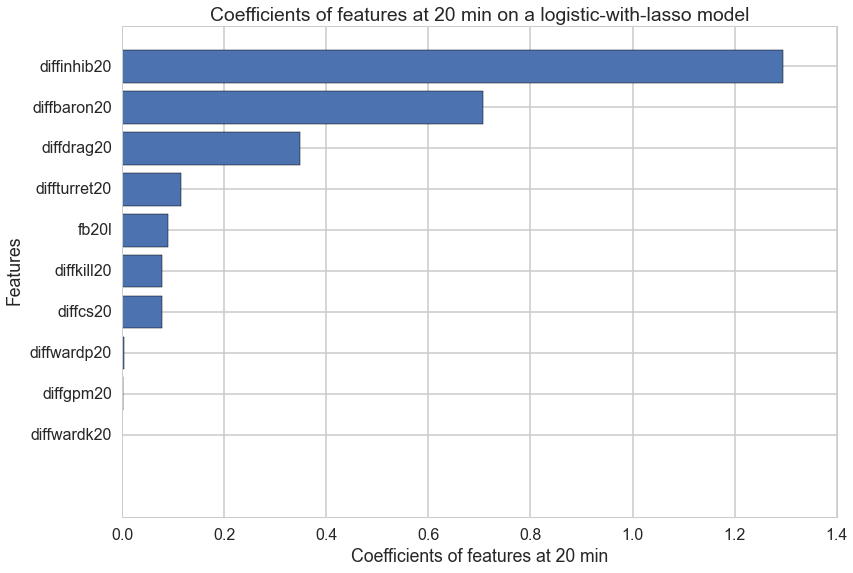

In [618]:
plt.barh(range(len(logcols2_sort)), coef2_sort,align='center')
plt.yticks(range(len(logcols2_sort)),logcols2_sort)
plt.xlabel('Coefficients of features at 20 min')
plt.ylabel('Features')
plt.title('Coefficients of features at 20 min on a logistic-with-lasso model')
plt.show()

30 min

In [619]:
lasso3 = LogisticRegression(penalty = 'l1')
clflog3, Xtrainlog3, ytrainlog3, Xtestlog3, ytestlog3 = do_classify(lasso3, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df3,lcols3, 'win',1, mask = mask)

using mask
BEST {'C': 0.1} 0.889649450322 [mean: 0.87582, std: 0.01095, params: {'C': 0.001}, mean: 0.88799, std: 0.00474, params: {'C': 0.01}, mean: 0.88965, std: 0.00539, params: {'C': 0.1}, mean: 0.88917, std: 0.00548, params: {'C': 1.0}, mean: 0.88930, std: 0.00539, params: {'C': 10.0}, mean: 0.88917, std: 0.00563, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.89
Accuracy on test data:     0.88
[[2259  263]
 [ 311 1989]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [620]:
#Getting the coefficients of each features
coef3 = list(clflog3.coef_[0])

In [621]:
print lcols3
print coef3

['diffbaron30', 'diffcs30', 'diffdrag30', 'diffgpm30', 'diffinhib30', 'diffkill30', 'diffturret30', 'diffwardk30', 'diffwardp30', 'fb30l']
[0.36410502494012387, 0.060756019344814227, 0.40929061969553165, 0.0017053175284175205, 0.89037019041062249, 0.11488460189310759, 0.018566240150912555, 0.00068136777581114308, 0.002852939964753201, 0.18139689061787129]


In [622]:
coef3_sort, logcols3_sort = zip(*sorted(zip(coef3, lcols3)))

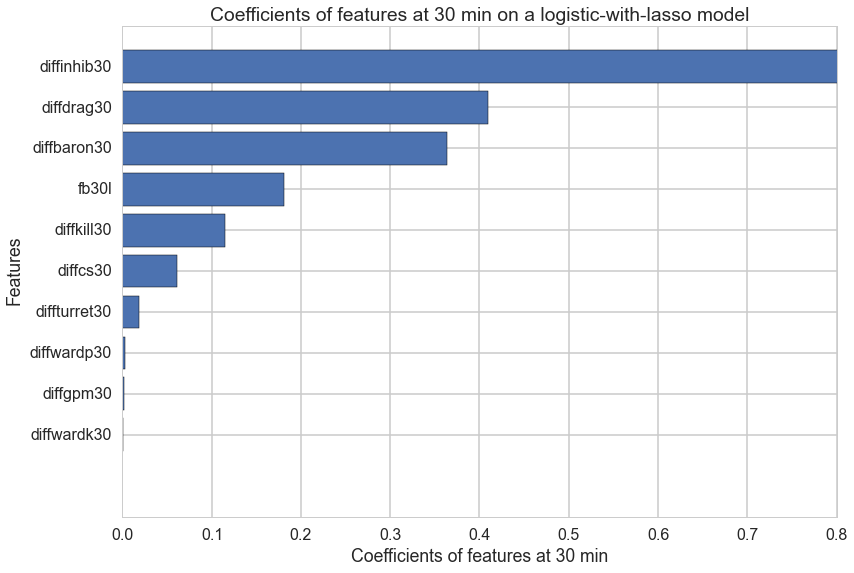

In [623]:
plt.barh(range(len(logcols3_sort)), coef3_sort,align='center')
plt.yticks(range(len(logcols3_sort)),logcols3_sort)
plt.xlabel('Coefficients of features at 30 min')
plt.xlim((0, 0.8))
plt.ylabel('Features')
plt.title('Coefficients of features at 30 min on a logistic-with-lasso model')
plt.show()

Logistic on the whole thing

In [624]:
logcols = list(df.columns.values)
logcols.remove('matchid')
logcols.remove('win')
logcols

['diffbaron10',
 'diffbaron20',
 'diffbaron30',
 'diffcs10',
 'diffcs20',
 'diffcs30',
 'diffdrag10',
 'diffdrag20',
 'diffdrag30',
 'diffgpm10',
 'diffgpm20',
 'diffgpm30',
 'diffinhib10',
 'diffinhib20',
 'diffinhib30',
 'diffkill10',
 'diffkill20',
 'diffkill30',
 'diffturret10',
 'diffturret20',
 'diffturret30',
 'diffwardk10',
 'diffwardk20',
 'diffwardk30',
 'diffwardp10',
 'diffwardp20',
 'diffwardp30',
 'fb10l',
 'fb20l',
 'fb30l',
 'gametimes']

In [625]:
wholelasso = LogisticRegression(penalty = 'l1')
clflogx, Xtrainlogx, ytrainlogx, Xtestlogx, ytestlogx = do_classify(wholelasso, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df,logcols, 'win',1, mask = mask)

using mask
BEST {'C': 10.0} 0.914333125907 [mean: 0.90617, std: 0.00907, params: {'C': 0.001}, mean: 0.90977, std: 0.00735, params: {'C': 0.01}, mean: 0.91413, std: 0.00747, params: {'C': 0.1}, mean: 0.91406, std: 0.00795, params: {'C': 1.0}, mean: 0.91433, std: 0.00806, params: {'C': 10.0}, mean: 0.91419, std: 0.00836, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.92
Accuracy on test data:     0.91
[[2304  212]
 [ 219 2087]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20214 but corresponding boolean dimension is 19285


In [626]:
#Getting the coefficients of each features
coefx = list(clflogx.coef_[0])

In [627]:
print coefx

[0.0, 0.20575885746219738, 0.36360176222292168, -0.022936835076209933, 0.025999846094297056, 0.0488785852660088, 0.27514126506622749, 0.2700231109066491, 0.26652489220995668, 0.0020150492591318719, 0.0010444635357010554, 0.0015450900817922184, 2.7885178122808836, 1.6060742011144513, 0.23004782756786515, -0.049741194534461686, 0.059750062622630475, 0.1325332986599754, 0.040012255251219417, 0.15620277019775475, 0.11576624824634096, 0.035894271769644215, -0.010619106400889367, -4.1125981630883739e-05, 0.0083562657895946899, 0.0019187527671264977, 0.0023107699905171204, -0.25849461138069668, 0.11607505770950728, 0.10135559760916761, -9.5434748395188372e-05]


In [628]:
coefx_sort, logcolsx_sort = zip(*sorted(zip(coefx, logcols)))

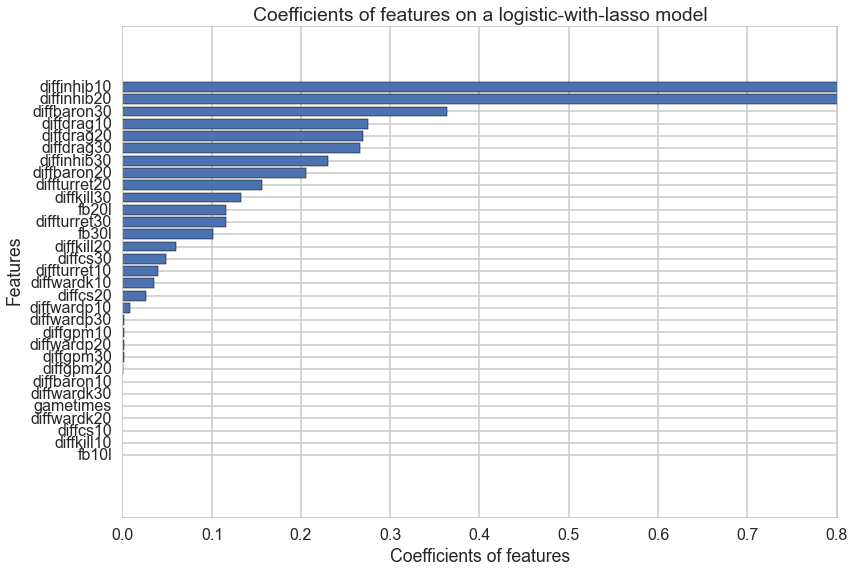

In [629]:
plt.barh(range(len(logcolsx_sort)), coefx_sort,align='center')
plt.yticks(range(len(logcolsx_sort)),logcolsx_sort)
plt.xlabel('Coefficients of features')
plt.xlim((0, 0.8))
plt.ylabel('Features')
plt.title('Coefficients of features on a logistic-with-lasso model')
plt.show()